## Feature analysis with calculated count tables: HCT116
<p style="text-align: right;"> Written by Soomin Son
<p style="text-align: right;"> Last revised: 06. 03. 2021.</p>

---
## Settings

In [1]:
import sys
sys.path.append('/casa/soomin/miniconda3/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.8/site-packages')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib_venn import venn2

from scipy import stats
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

import numpy as np
import pybedtools
import seaborn as sns
sns.set(style="ticks", palette="muted")

In [2]:
from matplotlib import font_manager

font_dirs = ['/casa/soomin/font/Helvetica/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

--- 
## Gathering information
### Read pre-processed tables

- DD_filtered, DI_filtered: filtered with baseMean cutoff (median value)

In [3]:
DD_filtered = \
pd.read_csv("Results/200914_HCT116_DD_filtered.csv")[['mature', 'baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj', \
                                                      'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start',\
                                                      'pri End', 'strand', 'Clustered', 'Locus', 'Exon_Intron', 'HostGene', 'Direction']].set_index("mature")
DI_filtered = \
pd.read_csv("Results/200914_HCT116_DI_filtered.csv")[['mature', 'baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj',\
                                                      'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start',\
                                                      'pri End', 'strand', 'Clustered', 'Locus', 'Exon_Intron', 'HostGene', 'Direction']].set_index("mature")

In [4]:
DD_filtered.columns

Index(['baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj',
       'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start',
       'pri End', 'strand', 'Clustered', 'Locus', 'Exon_Intron', 'HostGene',
       'Direction'],
      dtype='object')

In [5]:
DD_filtered.isna().sum()

baseMean                               0
log2FoldChange                         0
stat                                   0
pvalue                                 0
padj                                   0
curated DROSHA dependency (HCT116)     0
pri-miRNA                             29
Chr                                   29
pri Start                             29
pri End                               29
strand                                29
Clustered                             29
Locus                                 29
Exon_Intron                           29
HostGene                              29
Direction                             29
dtype: int64

In [6]:
# The number of ambiguous mature miRNAs with more than 1 pri-miRNAs
DD_filtered[DD_filtered['pri-miRNA'].isna()].shape

(29, 16)

In [7]:
# Drop the ambigous mature miRNAs for further feature analysis
DD_filtered = DD_filtered[~DD_filtered['pri-miRNA'].isna()]
DD_filtered.isna().sum()

baseMean                              0
log2FoldChange                        0
stat                                  0
pvalue                                0
padj                                  0
curated DROSHA dependency (HCT116)    0
pri-miRNA                             0
Chr                                   0
pri Start                             0
pri End                               0
strand                                0
Clustered                             0
Locus                                 0
Exon_Intron                           0
HostGene                              0
Direction                             0
dtype: int64

In [8]:
# Get the pri-miRNA list for motif search
pri_list = list(DD_filtered.loc[:,'pri-miRNA'].drop_duplicates())
print(len(pri_list))

190


---
### The presence of motifs in pri_list

In [9]:
# Get the 125 mer sequence containing hairpin region
set_125mer = pd.read_excel('125mer_variable_region_(fin).xlsx', header=None, engine = 'openpyxl')
set_125mer = set_125mer.iloc[6:,:].rename(columns={0:'pri-miRNA', 1:'seq'}).set_index('pri-miRNA')
set_125mer = set_125mer.loc[pri_list, :]
print(set_125mer.shape)
set_125mer.tail()

(190, 1)


/casa/soomin/conda/envs/lab/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,seq
pri-miRNA,
hsa-mir-942,TTCTTCTTCAGCAAACATTAGGAGAGTATCTTCTCTGTTTTGGCCA...
hsa-mir-95,AGGTAGGATTGTGACACCCAACACAGTGGGCACTCAATAAATGTCT...
hsa-mir-96,CCGCACCAGTGCCATCTGCTTGGCCGATTTTGGCACTAGCACATTT...
hsa-mir-98,AGGATTCTGCTCATGCCAGGGTGAGGTAGTAAGTTGTATTGTTGTG...
hsa-mir-99b,CGGGGGCCCGGACTCCTGGGTCCTGGCACCCACCCGTAGAACCGAC...


In [10]:
# Get mature fasta file and transform into table

from Bio.SeqIO.FastaIO import SimpleFastaParser
with open('hsa_mature.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)
        
#converting lists to pandas Series    
s1 = pd.Series(identifiers, name='ID')
s2 = pd.Series(seqs, name='seq')

#Gathering Series into a pandas DataFrame and rename index as ID column
mature_fa = pd.DataFrame(dict(ID=s1, seq=s2)).set_index(['ID'])
print(mature_fa.shape)
mature_fa.head()

(2656, 1)


,seq
ID,
hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU
hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC
hsa-let-7a-2-3p,CUGUACAGCCUCCUAGCUUUCC
hsa-let-7b-5p,UGAGGUAGUAGGUUGUGUGGUU
hsa-let-7b-3p,CUAUACAACCUACUGCCUUCCC


In [11]:
set_125mer['5p_seq'] = 0
set_125mer['3p_seq'] = 0
needs_manual_curation = list()

# Find the sequence of 5p strand

for pri in set_125mer.index:
    name_5p = pri.replace('mir', 'miR') + str('-5p')
    try:
        set_125mer.loc[pri, '5p_seq'] = mature_fa.loc[name_5p, 'seq']
    except:
        try:
            set_125mer.loc[pri,'5p_seq'] = mature_fa.loc[('-').join(pri.replace('mir', 'miR').split('-')[:-1])+'-5p', 'seq']
        except:
            print('5p', pri)
            needs_manual_curation.append(pri)
        
print('\n')

# Find the sequence of 3p strand

for pri in set_125mer.index:
    name_3p = pri.replace('mir', 'miR') + str('-3p')
    try:
        set_125mer.loc[pri, '3p_seq'] = mature_fa.loc[name_3p, 'seq']
    except:
        try:
            set_125mer.loc[pri,'3p_seq'] = mature_fa.loc[('-').join(pri.replace('mir', 'miR').split('-')[:-1])+'-3p', 'seq']
        except:
            print('3p', pri)
            needs_manual_curation.append(pri)

5p hsa-mir-107
5p hsa-mir-151b
5p hsa-mir-2110
5p hsa-mir-3176
5p hsa-mir-326
5p hsa-mir-378c
5p hsa-mir-421
5p hsa-mir-4326
5p hsa-mir-449a
5p hsa-mir-551a
5p hsa-mir-577
5p hsa-mir-760
5p hsa-mir-935
5p hsa-mir-940


3p hsa-mir-107
3p hsa-mir-151b
3p hsa-mir-2110
3p hsa-mir-3176
3p hsa-mir-326
3p hsa-mir-378c
3p hsa-mir-421
3p hsa-mir-4326
3p hsa-mir-449a
3p hsa-mir-551a
3p hsa-mir-577
3p hsa-mir-760
3p hsa-mir-935
3p hsa-mir-940


In [12]:
needs_manual_curation = set(needs_manual_curation)
needs_manual_curation

{'hsa-mir-107',
 'hsa-mir-151b',
 'hsa-mir-2110',
 'hsa-mir-3176',
 'hsa-mir-326',
 'hsa-mir-378c',
 'hsa-mir-421',
 'hsa-mir-4326',
 'hsa-mir-449a',
 'hsa-mir-551a',
 'hsa-mir-577',
 'hsa-mir-760',
 'hsa-mir-935',
 'hsa-mir-940'}

In [13]:
(set_125mer['5p_seq']==0).sum(), (set_125mer['3p_seq']==0).sum()

(14, 14)

In [14]:
### DO MANUAL CURATION ### 
# top_line: annotated in mirbase
# bottom_line: annnotated in mirGeneDB or predicted from 3p

set_125mer.loc["hsa-mir-107", '3p_seq'] = 'AGCAGCAUUGUACAGGGCUAUCA'
set_125mer.loc["hsa-mir-107", '5p_seq'] = 'AGCUUCUUUACAGUGUUGCCUUG'

set_125mer.loc["hsa-mir-151b", '3p_seq'] = 'UCGAGGAGCUCACAGUCU'
set_125mer.loc["hsa-mir-151b", '5p_seq'] = 'UCUUCAGGGCUCCCGAGA'

set_125mer.loc["hsa-mir-2110", '5p_seq'] = 'UUGGGGAAACGGCCGCUGAGUG'
set_125mer.loc["hsa-mir-2110", '3p_seq'] = 'CACCGCGGUCUUUUCCUCCCAC'

set_125mer.loc["hsa-mir-3176", '3p_seq'] = 'ACUGGCCUGGGACUACCGG'
set_125mer.loc["hsa-mir-3176", '5p_seq'] = 'GGCAGCCUCGGGCCACACUCC'

set_125mer.loc["hsa-mir-326", '5p_seq'] = 'GGAGGCAGGGCCUUUGUGAAGGCG'
set_125mer.loc["hsa-mir-326", '3p_seq'] = 'CCUCUGGGCCCUUCCUCCAG'

set_125mer.loc["hsa-mir-378c", '5p_seq'] = 'ACUGGACUUGGAGUCAGAAGAGUGG'
set_125mer.loc["hsa-mir-378c", '3p_seq'] = 'AACUCUGACUUUGAAGGUGG'

set_125mer.loc["hsa-mir-421", '5p_seq'] = 'CUCAUUAAAUGUUUGUUGAAUGA'
set_125mer.loc["hsa-mir-421", '3p_seq'] = 'AUCAACAGACAUUAAUUGGGCG'

set_125mer.loc["hsa-mir-4326", '5p_seq'] = 'UGUUCCUCUGUCUCCCAGAC'
set_125mer.loc["hsa-mir-4326", '3p_seq'] = 'UGGGUGGAUGGAGCAGG'

set_125mer.loc["hsa-mir-449a", '5p_seq'] = 'UGGCAGUGUAUUGUUAGCUGGU'
set_125mer.loc["hsa-mir-449a", '3p_seq'] = 'CGGCUAACAUGCAACUGCUGUC'

set_125mer.loc["hsa-mir-551a", '5p_seq'] = 'GAAAUCCAGAGUGGGUGGGGCCA'
set_125mer.loc["hsa-mir-551a", '3p_seq'] = 'GCGACCCACUCUUGGUUUCCA'

set_125mer.loc["hsa-mir-577", '5p_seq'] = 'GUAGAUAAAAUAUUGGUACCUG'
set_125mer.loc["hsa-mir-577", '3p_seq'] = 'GGUUUCAAUACUUUAUCUGCUC'

set_125mer.loc["hsa-mir-760", '5p_seq'] = 'CCCCUCAGUCCACCAGAGCCCGGA'
set_125mer.loc["hsa-mir-760", '3p_seq'] = 'CGGCUCUGGGUCUGUGGGGAG'

set_125mer.loc["hsa-mir-935", '5p_seq'] = 'AGUGGCGGGAGCGGCCCCUCGGC'
set_125mer.loc["hsa-mir-935", '3p_seq'] = 'CCAGUUACCGCUUCCGCUACCGC'

set_125mer.loc["hsa-mir-940", '3p_seq'] = 'AAGGCAGGGCCCCCGCUCCCC'
set_125mer.loc["hsa-mir-940", '5p_seq'] = 'CCCCAGGAGCGGGGCCUGGGCAGCC'

In [15]:
(set_125mer['5p_seq']==0).sum(), (set_125mer['3p_seq']==0).sum()

(0, 0)

In [16]:
pri_info = set_125mer[~(set_125mer['5p_seq'] == 0)].copy()
print(pri_info.shape)
pri_info.head()

(190, 3)


,seq,5p_seq,3p_seq
pri-miRNA,,,
hsa-let-7a-2,AGCCATTGTGACTGCATGCTCCCAGGTTGAGGTAGTAGGTTGTATA...,UGAGGUAGUAGGUUGUAUAGUU,CUGUACAGCCUCCUAGCUUUCC
hsa-let-7b,TGCAAGGCCGGGCCTGGCGGGGTGAGGTAGTAGGTTGTGTGGTTTC...,UGAGGUAGUAGGUUGUGUGGUU,CUAUACAACCUACUGCCUUCCC
hsa-let-7c,ACATTGGAAGCTGTGTGCATCCGGGTTGAGGTAGTAGGTTGTATGG...,UGAGGUAGUAGGUUGUAUGGUU,CUGUACAACCUUCUAGCUUUCC
hsa-let-7d,AAAAAAAAATGGGTTCCTAGGAAGAGGTAGTAGGTTGCATAGTTTT...,AGAGGUAGUAGGUUGCAUAGUU,CUAUACGACCUGCUGCCUUUCU
hsa-let-7e,CTGTCCACCTGCCGCGCCCCCCGGGCTGAGGTAGGAGGTTGTATAG...,UGAGGUAGGAGGUUGUAUAGUU,CUAUACGGCCUCCUAGCUUUCC


#### UG absence/presence

- UG in position -13, -14, -15, -16 (coordination of U)

In [17]:
pri_info.loc[pri_info.index, "UG"] = "NoUG"
for pri in pri_info.index:
    end_5p = pri_info.loc[pri, 'seq'].find(pri_info.loc[pri, '5p_seq'].replace('U', 'T'))
    if end_5p == -1:
        print(pri)
    subseq = pri_info.loc[pri, 'seq'][end_5p-15:end_5p-11]
    if subseq.find("TG") != -1:
        pri_info.loc[pri, "UG"] = "UG"
        
pri_info["UG"].value_counts()

NoUG    112
UG       78
Name: UG, dtype: int64

#### UGU/GUG absense/presence
- UGU/GUG in position +21,+22,+23 (coordination of the first U or G)

In [18]:
pri_info.loc[pri_info.index, "UGU"] = "NoUGU"
for pri in pri_info.index:
    end_5p = pri_info.loc[pri, 'seq'].find(pri_info.loc[pri,'5p_seq'].replace('U', 'T'))
    if end_5p == -1:
        print(pri)
    subseq = pri_info.loc[pri, 'seq'][end_5p+20:end_5p+25]
    if subseq.find("TGT") * subseq.find("GTG") != 1:
        pri_info.loc[pri, "UGU"] = "UGU"
        
pri_info["UGU"].value_counts()

NoUGU    119
UGU       71
Name: UGU, dtype: int64

#### CNNC absence/presence

- CNNC in position -16, -17, -18, -19 (coordination of the first C)

In [19]:
pri_info.loc[pri_info.index, "CNNC"] = "NoCNNC"
for pri in pri_info.index:
    if pri_info.loc[pri, 'seq'].find(pri_info.loc[pri, '3p_seq'].replace('U', 'T')) == -1:
        print(pri)
    end_3p = pri_info.loc[pri, 'seq'].find(pri_info.loc[pri, '3p_seq'].replace('U', 'T')) + len(pri_info.loc[pri, '3p_seq'])
    if (pri_info.loc[pri, 'seq'][end_3p+15] == 'C') & (pri_info.loc[pri, 'seq'][end_3p+18] == 'C'):
        pri_info.loc[pri,'CNNC'] = "CNNC"
    elif (pri_info.loc[pri, 'seq'][end_3p+16] == 'C') & (pri_info.loc[pri, 'seq'][end_3p+19] == 'C'):
        pri_info.loc[pri,'CNNC'] = "CNNC"
    elif (pri_info.loc[pri, 'seq'][end_3p+17] == 'C') & (pri_info.loc[pri, 'seq'][end_3p+20] == 'C'):
        pri_info.loc[pri,'CNNC'] = "CNNC"
    elif (pri_info.loc[pri, 'seq'][end_3p+18] == 'C') & (pri_info.loc[pri, 'seq'][end_3p+21] == 'C'):
        pri_info.loc[pri,'CNNC'] = "CNNC"

pri_info["CNNC"].value_counts()

CNNC      134
NoCNNC     56
Name: CNNC, dtype: int64

### mGHG score

- Use the score at -7

In [20]:
mGHG_df = pd.read_excel('mGHG-S1.xlsx', sheet_name=2, engine = 'openpyxl').set_index('pri-miRNA')
mGHG_df = mGHG_df[['mGHG score at –7']]
mGHG_df.rename(columns={'mGHG score at –7': 'mGHG_score'}, inplace=True)
mGHG_df = mGHG_df[mGHG_df['mGHG_score'] != 'ND'].copy()
mGHG_df.head()

,mGHG_score
pri-miRNA,
hsa-let-7a-1,27.547628
hsa-let-7a-3,13.121459
hsa-let-7d,40.053494
hsa-let-7e,32.085647
hsa-let-7f-2,68.302013


In [21]:
pri_info = pri_info.join(mGHG_df, how='left')

In [22]:
pri_info_SM = pri_info[["UG", "UGU", "CNNC", "mGHG_score"]]
print(pri_info_SM.shape)
pri_info_SM.head()

(190, 4)


,UG,UGU,CNNC,mGHG_score
pri-miRNA,,,,
hsa-let-7a-2,UG,NoUGU,CNNC,NaN
hsa-let-7b,NoUG,NoUGU,CNNC,NaN
hsa-let-7c,UG,NoUGU,CNNC,NaN
hsa-let-7d,UG,NoUGU,CNNC,40.053494
hsa-let-7e,NoUG,NoUGU,NoCNNC,32.085647


Compare it with the preveious table used by BK before

In [23]:
pri_info_BK = pd.read_csv("../../work/190905_sRNA_HCT116_rescue_set_3/190712_pri-info_BK.csv", \
                          sep = ',').rename(columns={"Unnamed: 0": 'pri-miRNA'}).set_index('pri-miRNA')[['UG', 'UGU', 'CNNC']]

pri_info_BK["UG"] = np.where(pri_info_BK["UG"] == "-", "NoUG", "UG")
pri_info_BK["UGU"] = np.where(pri_info_BK["UGU"] == "-", "NoUGU", "UGU")
pri_info_BK["CNNC"] = np.where(pri_info_BK["CNNC"] == "-", "NoCNNC", "CNNC")

print(pri_info_BK.shape)
pri_info_BK.head()

(401, 3)


,UG,UGU,CNNC
pri-miRNA,,,
hsa-let-7a-1,NoUG,NoUGU,NoCNNC
hsa-let-7a-2,UG,NoUGU,CNNC
hsa-let-7a-3,UG,NoUGU,CNNC
hsa-let-7b,NoUG,NoUGU,NoCNNC
hsa-let-7c,UG,NoUGU,NoCNNC


In [24]:
table_comparison = pri_info_SM.join(pri_info_BK, how='inner', lsuffix='_SM', rsuffix='_BK')
table_comparison.head()

,UG_SM,UGU_SM,CNNC_SM,mGHG_score,UG_BK,UGU_BK,CNNC_BK
pri-miRNA,,,,,,,
hsa-let-7a-2,UG,NoUGU,CNNC,NaN,UG,NoUGU,CNNC
hsa-let-7b,NoUG,NoUGU,CNNC,NaN,NoUG,NoUGU,NoCNNC
hsa-let-7c,UG,NoUGU,CNNC,NaN,UG,NoUGU,NoCNNC
hsa-let-7e,NoUG,NoUGU,NoCNNC,32.085647,NoUG,NoUGU,NoCNNC
hsa-let-7f-1,UG,UGU,CNNC,NaN,NoUG,UGU,CNNC


In [25]:
# UG
(table_comparison["UG_SM"] == table_comparison["UG_BK"]).value_counts()

True     123
False     18
dtype: int64

In [26]:
table_comparison[table_comparison["UG_SM"] != table_comparison["UG_BK"]]

,UG_SM,UGU_SM,CNNC_SM,mGHG_score,UG_BK,UGU_BK,CNNC_BK
pri-miRNA,,,,,,,
hsa-let-7f-1,UG,UGU,CNNC,NaN,NoUG,UGU,CNNC
hsa-mir-1301,NoUG,UGU,CNNC,NaN,UG,NoUGU,CNNC
hsa-mir-1307,NoUG,NoUGU,NoCNNC,28.717459,UG,NoUGU,NoCNNC
hsa-mir-148a,UG,NoUGU,CNNC,17.194273,NoUG,NoUGU,CNNC
hsa-mir-187,NoUG,NoUGU,CNNC,NaN,UG,NoUGU,CNNC
hsa-mir-18a,NoUG,UGU,CNNC,60.290391,UG,NoUGU,CNNC
hsa-mir-23b,UG,UGU,CNNC,NaN,NoUG,UGU,CNNC
hsa-mir-24-2,NoUG,NoUGU,NoCNNC,NaN,UG,NoUGU,NoCNNC
hsa-mir-25,UG,NoUGU,CNNC,NaN,NoUG,NoUGU,CNNC


In [27]:
# UGU
(table_comparison["UGU_SM"] == table_comparison["UGU_BK"]).value_counts()

True     105
False     36
dtype: int64

In [28]:
table_comparison[table_comparison["UGU_SM"] != table_comparison["UGU_BK"]]

,UG_SM,UGU_SM,CNNC_SM,mGHG_score,UG_BK,UGU_BK,CNNC_BK
pri-miRNA,,,,,,,
hsa-mir-106b,NoUG,UGU,CNNC,23.325825,NoUG,NoUGU,CNNC
hsa-mir-107,NoUG,UGU,CNNC,66.434291,NoUG,NoUGU,CNNC
hsa-mir-1180,NoUG,UGU,CNNC,27.932178,NoUG,NoUGU,CNNC
hsa-mir-125a,UG,UGU,CNNC,95.926412,UG,NoUGU,CNNC
hsa-mir-1301,NoUG,UGU,CNNC,NaN,UG,NoUGU,CNNC
hsa-mir-146b,UG,UGU,CNNC,NaN,UG,NoUGU,NoCNNC
hsa-mir-17,NoUG,UGU,CNNC,30.145196,NoUG,NoUGU,CNNC
hsa-mir-181d,NoUG,NoUGU,CNNC,76.31296,NoUG,UGU,CNNC
hsa-mir-183,NoUG,UGU,CNNC,65.067093,NoUG,NoUGU,NoCNNC


In [29]:
# CNNC
(table_comparison["CNNC_SM"] == table_comparison["CNNC_BK"]).value_counts()

True     125
False     16
dtype: int64

In [30]:
table_comparison[table_comparison["CNNC_SM"] != table_comparison["CNNC_BK"]]

,UG_SM,UGU_SM,CNNC_SM,mGHG_score,UG_BK,UGU_BK,CNNC_BK
pri-miRNA,,,,,,,
hsa-let-7b,NoUG,NoUGU,CNNC,NaN,NoUG,NoUGU,NoCNNC
hsa-let-7c,UG,NoUGU,CNNC,NaN,UG,NoUGU,NoCNNC
hsa-mir-1247,NoUG,NoUGU,CNNC,NaN,NoUG,NoUGU,NoCNNC
hsa-mir-146b,UG,UGU,CNNC,NaN,UG,NoUGU,NoCNNC
hsa-mir-183,NoUG,UGU,CNNC,65.067093,NoUG,NoUGU,NoCNNC
hsa-mir-22,UG,UGU,CNNC,NaN,UG,UGU,NoCNNC
hsa-mir-33b,NoUG,UGU,CNNC,40.895103,NoUG,NoUGU,NoCNNC
hsa-mir-365b,NoUG,UGU,CNNC,6.293472,NoUG,UGU,NoCNNC
hsa-mir-374b,NoUG,UGU,CNNC,40.895103,NoUG,UGU,NoCNNC


From now on, use pri_info_SM for motif information

---
### Redefine clustered miRNAs with distance cutoff 2000
### With miRBase annotation (pri Start, pri End)

- Our current length criteria for clustered miRNA was 10 kb.
- 10 kb is too long, therefore many miRNAs are classified into clustered miRNAs.
- Recent papers mentioning cluster assistance say that, 2 kb is the upper limit of cluster assistance.
- So, I decided to change cluster length criteria and perform analysis with log2 (delN200/del10).
- Distance between 2 pri-miRNAs is 5' mirbase pri ~ 5' mirbase pri.

In [31]:
mature_info = pd.read_table("200326_curated_hg38_mature_miRNA_classification.txt")
mature_info.head()

,mature miRNA,Chr,mature Start,mature End,strand,pri miRNA,pri Start,pri End,DROSHA dependency,Clustered,Locus,Exon_Intron,HostGene,Direction,curated DROSHA dependency (HCT116)
0,hsa-miR-6859-5p,chr1,17409,17431,-,hsa-mir-6859-1,17369,17436,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
1,hsa-miR-6859-3p,chr1,17369,17391,-,hsa-mir-6859-1,17369,17436,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
2,hsa-miR-1302,chr1,30438,30458,+,hsa-mir-1302-2,30366,30503,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
3,hsa-miR-6859-5p,chr1,187931,187953,-,hsa-mir-6859-2,187891,187958,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
4,hsa-miR-6859-3p,chr1,187891,187913,-,hsa-mir-6859-2,187891,187958,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN


In [32]:
cluster_info = mature_info[['pri miRNA', 'Chr', 'strand', 'pri Start', 'pri End', 'Clustered']].set_index('pri miRNA')
cluster_info.drop_duplicates(inplace=True)
print(cluster_info.shape)
cluster_info.head()

(1881, 5)


,Chr,strand,pri Start,pri End,Clustered
pri miRNA,,,,,
hsa-mir-6859-1,chr1,-,17369,17436,independent
hsa-mir-1302-2,chr1,+,30366,30503,independent
hsa-mir-6859-2,chr1,-,187891,187958,independent
hsa-mir-6723,chr1,-,632325,632413,independent
hsa-mir-200b,chr1,+,1167104,1167198,clustered


In [33]:
neighbor_dict = {}
threshold = 2000

In [34]:
### Gather miRNAs in the same chromosome and strand (chr_strand)
### And then do iteration

for chromosome in set(cluster_info['Chr']):
    for strand in set(cluster_info['strand']):
        chr_strand = cluster_info[(cluster_info['Chr'] == chromosome) & (cluster_info['strand'] == strand)]
        if strand == '+':
            for pri1, row1 in chr_strand.iterrows():
                for pri2, row2 in chr_strand.iterrows():
                    if (0 < abs(row1['pri Start'] - row2['pri Start'])) & (abs(row1['pri Start'] - row2['pri Start']) < threshold):
                        try:
                            neighbor_dict[pri1][pri2] = abs(row1['pri Start'] - row2['pri Start'])
                        except:
                            neighbor_dict[pri1]={}
                            neighbor_dict[pri1][pri2] = abs(row1['pri Start'] - row2['pri Start'])
        if strand == '-':
            for pri1, row1 in chr_strand.iterrows():
                for pri2, row2 in chr_strand.iterrows():
                    if (0 < abs(row1['pri End'] - row2['pri End'])) & (abs(row1['pri End'] - row2['pri End']) < threshold):
                        try:
                            neighbor_dict[pri1][pri2] = abs(row1['pri End'] - row2['pri End'])
                        except:
                            neighbor_dict[pri1]={}
                            neighbor_dict[pri1][pri2] = abs(row1['pri End'] - row2['pri End'])

In [35]:
for pri, row in cluster_info.iterrows():
    if pri in neighbor_dict.keys():
        cluster_info.loc[pri, 'Clustered_2000'] = 'clustered'
    else:
        cluster_info.loc[pri, 'Clustered_2000'] = 'independent'

In [36]:
cluster_info.head()

,Chr,strand,pri Start,pri End,Clustered,Clustered_2000
pri miRNA,,,,,,
hsa-mir-6859-1,chr1,-,17369,17436,independent,independent
hsa-mir-1302-2,chr1,+,30366,30503,independent,independent
hsa-mir-6859-2,chr1,-,187891,187958,independent,independent
hsa-mir-6723,chr1,-,632325,632413,independent,independent
hsa-mir-200b,chr1,+,1167104,1167198,clustered,clustered


In [37]:
# Compare new category with previous one
pd.crosstab(DD_filtered.join(cluster_info["Clustered_2000"], on ='pri-miRNA', how='left')['Clustered_2000'], \
            DD_filtered.join(cluster_info["Clustered_2000"], on ='pri-miRNA', how='left')['Clustered'])

Clustered,clustered,independent
Clustered_2000,,
clustered,112,1
independent,19,147


### Analysis for the association between the P-rich dependency and the location within clusters

- Get miRNA clusters, if a hairpin is located under 2000 nt length, it is included in the same cluster.

In [38]:
tmp_group = list()
for key_x in neighbor_dict.keys():
    tmp_set = set()
    tmp_set.add(key_x)
    tmp_set= frozenset(tmp_set.union(set(neighbor_dict[key_x].keys())))
    
    tmp_group.append(tmp_set)
     
print(len(tmp_group))

tmp_group = list(set(tmp_group))

print(len(tmp_group))

270
143


cluster_list contains all miRNAs within a single cluster.

In [39]:
tmp_group

[frozenset({'hsa-mir-519b', 'hsa-mir-526b'}),
 frozenset({'hsa-mir-154', 'hsa-mir-496'}),
 frozenset({'hsa-mir-518f', 'hsa-mir-520b', 'hsa-mir-523'}),
 frozenset({'hsa-mir-362', 'hsa-mir-500b', 'hsa-mir-501'}),
 frozenset({'hsa-mir-1185-1',
            'hsa-mir-300',
            'hsa-mir-376a-1',
            'hsa-mir-376a-2',
            'hsa-mir-376b',
            'hsa-mir-376c',
            'hsa-mir-654'}),
 frozenset({'hsa-mir-1914', 'hsa-mir-647'}),
 frozenset({'hsa-mir-1193', 'hsa-mir-494', 'hsa-mir-543'}),
 frozenset({'hsa-mir-1197',
            'hsa-mir-323a',
            'hsa-mir-329-1',
            'hsa-mir-329-2',
            'hsa-mir-758'}),
 frozenset({'hsa-mir-1185-2',
            'hsa-mir-381',
            'hsa-mir-487b',
            'hsa-mir-539',
            'hsa-mir-889'}),
 frozenset({'hsa-mir-1197',
            'hsa-mir-323a',
            'hsa-mir-329-1',
            'hsa-mir-329-2',
            'hsa-mir-380',
            'hsa-mir-758'}),
 frozenset({'hsa-mir-337', '

In [40]:
tmp_group2 = list()

while len(tmp_group) != len(tmp_group2):
    tmp_group2 = list()
    for set1 in tmp_group:
        tmp = list()
        tmp.append(set(set1))
        for set2 in [s for s in tmp_group if s != set1]:
            if set1.intersection(set2) != set():
                tmp.append(set(set2))
        tmp_group2.append(frozenset(set.union(*tmp)))
    tmp_group = list(set(tmp_group2))
    print(len(set(tmp_group2)))
    
cluster_list = list(tmp_group2)

105
95
95


In [41]:
cluster_list

[frozenset({'hsa-mir-519b', 'hsa-mir-526b'}),
 frozenset({'hsa-mir-1914', 'hsa-mir-647'}),
 frozenset({'hsa-mir-337', 'hsa-mir-665'}),
 frozenset({'hsa-mir-181a-1', 'hsa-mir-181b-1'}),
 frozenset({'hsa-mir-449a', 'hsa-mir-449b', 'hsa-mir-449c'}),
 frozenset({'hsa-let-7a-3', 'hsa-let-7b', 'hsa-mir-4763'}),
 frozenset({'hsa-mir-517c', 'hsa-mir-518a-2', 'hsa-mir-520h'}),
 frozenset({'hsa-mir-509-1', 'hsa-mir-509-2', 'hsa-mir-509-3'}),
 frozenset({'hsa-mir-517b', 'hsa-mir-520d', 'hsa-mir-520g'}),
 frozenset({'hsa-mir-181a-2', 'hsa-mir-181b-2'}),
 frozenset({'hsa-mir-515-1', 'hsa-mir-519e'}),
 frozenset({'hsa-mir-4450', 'hsa-mir-548ah'}),
 frozenset({'hsa-mir-296', 'hsa-mir-298'}),
 frozenset({'hsa-mir-599', 'hsa-mir-875'}),
 frozenset({'hsa-mir-941-1',
            'hsa-mir-941-2',
            'hsa-mir-941-3',
            'hsa-mir-941-4',
            'hsa-mir-941-5'}),
 frozenset({'hsa-mir-362', 'hsa-mir-500a', 'hsa-mir-500b', 'hsa-mir-501'}),
 frozenset({'hsa-mir-518c', 'hsa-mir-520c', 'hs

In [42]:
cluster_info["cluster_order"] = -3
cluster_info["cluster_id"] = -3
cluster_info["cluster_len"] = -3


for i in range(len(cluster_list)):
    range_num = list(range(len(cluster_list[i])))
    if cluster_info.loc[cluster_list[i], :].iloc[0,1] == '+':
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_order"] = range_num
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_id"] = i
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_len"] = len(cluster_list[i])
    elif cluster_info.loc[cluster_list[i], :].iloc[0,1] == '-':
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_order"] = range_num
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_id"] = i
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_len"] = len(cluster_list[i]) 
    else:
        print("Strange!")

In [43]:
cluster_info.tail()

,Chr,strand,pri Start,pri End,Clustered,Clustered_2000,cluster_order,cluster_id,cluster_len
pri miRNA,,,,,,,,,
hsa-mir-1184-1,chrX,-,154887360,154887458,independent,independent,-3,-3,-3
hsa-mir-1184-2,chrX,-,155383100,155383198,independent,independent,-3,-3,-3
hsa-mir-1184-3,chrX,+,155457517,155457615,independent,independent,-3,-3,-3
hsa-mir-3690-2,chrY,+,1293918,1293992,independent,independent,-3,-3,-3
hsa-mir-6089-2,chrY,+,2609191,2609254,independent,independent,-3,-3,-3


In [44]:
cluster_info[cluster_info["cluster_id"]==94]

,Chr,strand,pri Start,pri End,Clustered,Clustered_2000,cluster_order,cluster_id,cluster_len
pri miRNA,,,,,,,,,
hsa-mir-7113,chr11,+,68032864,68032922,clustered,clustered,0,94,2
hsa-mir-4691,chr11,+,68033897,68033981,clustered,clustered,1,94,2


In [45]:
cluster_info["cluster_rel_order"] = -3
cluster_info["cluster_rel_order"] = cluster_info["cluster_order"] / (cluster_info["cluster_len"]-1)


cluster_info.loc[cluster_info[cluster_info["cluster_rel_order"] == 0].index, "cluster_rel_label"] = "First"
cluster_info.loc[cluster_info[cluster_info["cluster_rel_order"] == 1].index, "cluster_rel_label"] = "Last"
cluster_info.loc[cluster_info[(cluster_info["cluster_rel_order"] !=0) & (cluster_info["cluster_rel_order"] !=1) & (cluster_info["cluster_rel_order"] != 0.75)].index, "cluster_rel_label"] = "Middle"
cluster_info.loc[cluster_info[cluster_info["Clustered_2000"] == 'independent'].index, "cluster_rel_label"] = "Stand-alone"

cluster_info.head()

,Chr,strand,pri Start,pri End,Clustered,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label
pri miRNA,,,,,,,,,,,
hsa-mir-6859-1,chr1,-,17369,17436,independent,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-1302-2,chr1,+,30366,30503,independent,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-6859-2,chr1,-,187891,187958,independent,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-6723,chr1,-,632325,632413,independent,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-200b,chr1,+,1167104,1167198,clustered,clustered,0,82,3,0.00,First


In [46]:
pd.crosstab(cluster_info["Clustered_2000"], cluster_info["cluster_rel_label"])

cluster_rel_label,First,Last,Middle,Stand-alone
Clustered_2000,,,,
clustered,95,95,74,0
independent,0,0,0,1611


In [47]:
cluster_info_SM = \
cluster_info[["Clustered_2000", "cluster_order", "cluster_id", "cluster_len", "cluster_rel_order", "cluster_rel_label"]]

cluster_info_SM.head()

,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label
pri miRNA,,,,,,
hsa-mir-6859-1,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-1302-2,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-6859-2,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-6723,independent,-3,-3,-3,0.75,Stand-alone
hsa-mir-200b,clustered,0,82,3,0.00,First


---
### Redefine intergenic/exonic/intronic -> exonic/intronic

#### Get the coordinates of pri-miRNA start and end for intronic miRNAs
- Original mirbase: 1-based, closed interval( [,] )
- Change the coordinates of pri-miRNA start and end to 0-based and half-open interval.
- Classified them into intronic & independent and intronic & clustered

- pri Start = pri Start - 1
- pri End = pri End 

#### Get the coordinates of intron regions from UCSC genome browser
- genome: hg38
- group: Genes and Gene Predictions
- track: NCBI RefSeq, table: RefSeq Curated (ncbiRefSeqCurated)
- 0-based, half open

Coordinates of pri-miRNA in DD_filtered

In [48]:
tmp = DD_filtered.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]].copy()
tmp["pri Start"] = tmp['pri Start'] - 1
tmp["pri End"] = tmp["pri End"]

tmp['score'] = 0

tmp = tmp[['Chr', 'pri Start', 'pri End', 'mature', 'score', 'strand']]

tmp.dropna(inplace=True)
tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

miRNA_bed = pybedtools.BedTool.from_dataframe(tmp)
miRNA_bed.head()

chr11	122146521	122146593	hsa-let-7a-2-3p	0	-
 chr22	46113685	46113768	hsa-let-7b-3p	0	+
 chr22	46113685	46113768	hsa-let-7b-5p	0	+
 chr21	16539827	16539911	hsa-let-7c-5p	0	+
 chr9	94178833	94178920	hsa-let-7d-3p	0	+
 chr9	94178833	94178920	hsa-let-7d-5p	0	+
 chr19	51692785	51692864	hsa-let-7e-3p	0	+
 chr19	51692785	51692864	hsa-let-7e-5p	0	+
 chr9	94176346	94176433	hsa-let-7f-1-3p	0	+
 chrX	53557191	53557274	hsa-let-7f-2-3p	0	-
 

Coordinates of introns

In [49]:
genome_df = pd.read_table('hg38_RefSeq_Curated_intron.bed')
genome_df.head()

,chr1,67093604,67096251,NM_001276352.2_intron_0_0_chr1_67093605_r,0,-
0,chr1,67096321,67103237,NM_001276352.2_intron_1_0_chr1_67096322_r,0,-
1,chr1,67103382,67111576,NM_001276352.2_intron_2_0_chr1_67103383_r,0,-
2,chr1,67111644,67115351,NM_001276352.2_intron_3_0_chr1_67111645_r,0,-
3,chr1,67115464,67125751,NM_001276352.2_intron_4_0_chr1_67115465_r,0,-
4,chr1,67125909,67127165,NM_001276352.2_intron_5_0_chr1_67125910_r,0,-


In [50]:
genome_bed = pybedtools.BedTool.from_dataframe(genome_df)

In [51]:
# A: intronic miRNA region
# B: intron regions of genomes


miRNA_intron_intersect = pybedtools.BedTool(miRNA_bed).intersect(genome_bed, wa=True, wb=True, f=1, s=True)
miRNA_intron_intersect = pybedtools.BedTool.to_dataframe(miRNA_intron_intersect)
print(miRNA_intron_intersect.shape)

miRNA_intron_intersect.head()

(1122, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_137183.1_intron_0_0_chr11_122091741_r,0,-
1,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091719,122155550,NR_137185.1_intron_0_0_chr11_122091720_r,0,-
2,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_024430.2_intron_0_0_chr11_122091741_r,0,-
3,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091719,122155550,NR_137182.1_intron_0_0_chr11_122091720_r,0,-
4,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_137180.1_intron_0_0_chr11_122091741_r,0,-


In [52]:
pd.crosstab(miRNA_intron_intersect["strand"], miRNA_intron_intersect["blockStarts"])

blockStarts,+,-
strand,,
+,510,0
-,0,612


In [53]:
intronic_list = list(miRNA_intron_intersect.drop_duplicates(subset='name', keep='first').set_index("name").index)
len(intronic_list)

190

In [54]:
exonic_list = list(set(DD_filtered.index) - set(intronic_list))
len(exonic_list)

89

In [55]:
genome_location_SM = pd.DataFrame(index = DD_filtered.index)
genome_location_SM["Exon_Intron"] = -3
genome_location_SM.loc[intronic_list, "Exon_Intron"] = "intronic"
genome_location_SM.loc[exonic_list, "Exon_Intron"] = "exonic"

genome_location_SM.head()

,Exon_Intron
mature,
hsa-let-7a-2-3p,intronic
hsa-let-7b-3p,exonic
hsa-let-7b-5p,exonic
hsa-let-7c-5p,intronic
hsa-let-7d-3p,intronic


In [56]:
genome_location_SM["Exon_Intron"].value_counts()

intronic    190
exonic       89
Name: Exon_Intron, dtype: int64

In [57]:
# Comparing previous information

pd.crosstab(DD_filtered.join(genome_location_SM, lsuffix='_BK', rsuffix='_SM')["Exon_Intron_BK"], \
            DD_filtered.join(genome_location_SM, lsuffix='_BK', rsuffix='_SM')["Exon_Intron_SM"])

Exon_Intron_SM,exonic,intronic
Exon_Intron_BK,,
exonic,12,8
intergenic,69,48
intronic,8,134


In [58]:
# Check individual miRNAs thant are classified into different groups

tmp = DD_filtered.join(genome_location_SM, lsuffix='_BK', rsuffix='_SM')

#tmp[(tmp["Exon_Intron_BK"] == 'intergenic')&(tmp["Exon_Intron_SM"] == 'intronic')]
#tmp[(tmp["Exon_Intron_BK"] == 'exonic')&(tmp["Exon_Intron_SM"] == 'intronic')]
tmp[(tmp["Exon_Intron_BK"] == 'intronic')&(tmp["Exon_Intron_SM"] == 'exonic')]

,baseMean,log2FoldChange,stat,pvalue,padj,curated DROSHA dependency (HCT116),pri-miRNA,Chr,pri Start,pri End,strand,Clustered,Locus,Exon_Intron_BK,HostGene,Direction,Exon_Intron_SM
mature,,,,,,,,,,,,,,,,,
hsa-miR-151b,93.872281,-1.160490,-4.160122,3.180780e-05,2.918366e-04,DROSHA-dependent,hsa-mir-151b,chr14,100109419.0,100109514.0,-,independent,intragenic,intronic,EVL,-+,exonic
hsa-miR-199b-3p,19.087805,0.184415,0.415488,6.777843e-01,7.497419e-01,DROSHA-dependent,hsa-mir-199b,chr9,128244721.0,128244830.0,-,clustered,intragenic,intronic,DNM1,-+,exonic
hsa-miR-199b-5p,17.739507,0.163200,0.332922,7.391930e-01,8.038039e-01,DROSHA-dependent,hsa-mir-199b,chr9,128244721.0,128244830.0,-,clustered,intragenic,intronic,DNM1,-+,exonic
hsa-miR-3065-5p,30.594673,-3.672162,-6.055347,1.401155e-09,3.317573e-08,DROSHA-dependent,hsa-mir-3065,chr17,81125877.0,81125955.0,+,independent,intragenic,intronic,AATK,+-,exonic
hsa-miR-324-3p,283.643532,0.049427,0.201921,8.399785e-01,8.871140e-01,DROSHA-dependent,hsa-mir-324,chr17,7223297.0,7223379.0,-,independent,intragenic,intronic,ACADVL,-+,exonic
hsa-miR-324-5p,555.753469,0.178670,0.654876,5.125478e-01,6.097408e-01,DROSHA-dependent,hsa-mir-324,chr17,7223297.0,7223379.0,-,independent,intragenic,intronic,ACADVL,-+,exonic
hsa-miR-328-3p,36.454492,0.250276,0.674550,4.999616e-01,5.967022e-01,DROSHA-dependent,hsa-mir-328,chr16,67202321.0,67202395.0,-,independent,intragenic,intronic,ELMO3,-+,exonic
hsa-miR-760,27.682899,0.577409,1.271194,2.036596e-01,2.919652e-01,DROSHA-dependent,hsa-mir-760,chr1,93846832.0,93846911.0,+,independent,intragenic,intronic,BCAR3,+-,exonic


---
### Join the tables -> DD_analysis

- DD_filtered: 'baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj', 'pri-miRNA'


- pri_info_SM: 'UG', 'UGU', 'CNNC', 'mGHG_score'


- cluster_info_SM: 'Clustered_2000', 'cluster_order', 'cluster_id', 'cluster_len', 'cluster_rel_order', 'cluster_rel_label'


- genome_location_SM: 'Exon_Intron'

In [59]:
DD_analysis = \
DD_filtered[['baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj', 'pri-miRNA']].join(pri_info_SM, on='pri-miRNA', how='left')

DD_analysis= \
DD_analysis.join(cluster_info_SM, on='pri-miRNA', how='left')

DD_analysis= \
DD_analysis.join(genome_location_SM, how='left')

print(DD_analysis.isna().sum())
DD_analysis.head()

baseMean              0
log2FoldChange        0
stat                  0
pvalue                0
padj                  0
pri-miRNA             0
UG                    0
UGU                   0
CNNC                  0
mGHG_score           67
Clustered_2000        0
cluster_order         0
cluster_id            0
cluster_len           0
cluster_rel_order     0
cluster_rel_label     0
Exon_Intron           0
dtype: int64


,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,5,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,5,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,75,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.053494,independent,-3,-3,-3,0.75,Stand-alone,intronic


---
## Association analysis with DD_analysis

### UG/UGU/CNNC/mGHG motif

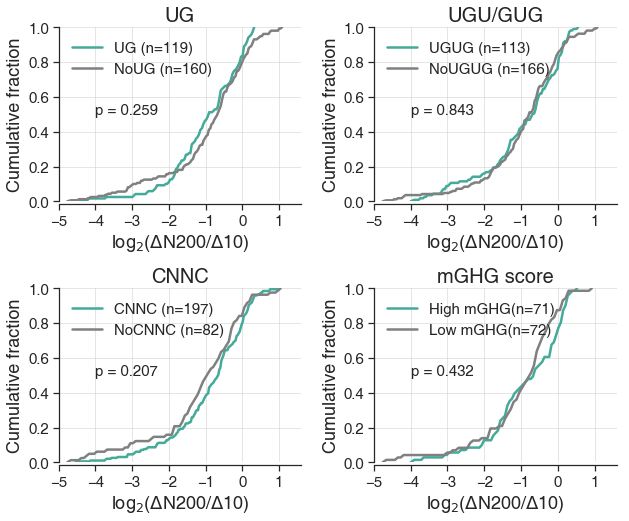

In [61]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

#################### ax[0,0] : UG ####################

UG = DD_analysis[DD_analysis["UG"] == "UG"]['log2FoldChange']
NoUG = DD_analysis[DD_analysis["UG"] == "NoUG"]['log2FoldChange']

### evaluate the histogram
UG_values, UG_base = np.histogram(UG, bins = len(UG))
NoUG_values, NoUG_base = np.histogram(NoUG, bins = len(NoUG))

### evaluate cumulative
UG_cumulative = np.cumsum(UG_values) / np.sum(UG_values)
NoUG_cumulative = np.cumsum(NoUG_values) / np.sum(NoUG_values)

ax[0,0].plot(np.insert(UG_base[:-1], 0, UG_base[0]-0.1, axis = 0), \
        np.insert(UG_cumulative,0,0, axis=0), label='UG '+'(n='+str(len(UG))+")", \
        color = '#44AA99', linewidth=2.5)
ax[0,0].plot(np.insert(NoUG_base[:-1],0,NoUG_base[0]-0.1, axis=0),\
       np.insert(NoUG_cumulative,0,0,axis=0), label="NoUG " + "(n=" +str(len(NoUG))+")",\
       color='#808080', linewidth=2.5)

ax[0,0].set_xlim(-5,1.6)
ax[0,0].set_ylim(0,1)
ax[0,0].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[0,0].set_ylabel("Cumulative fraction", fontsize=18)
ax[0,0].set_title("UG", fontsize=20)
ax[0,0].legend(frameon=False, loc="upper left", fontsize=15)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].grid(axis='x', alpha=0.5)
ax[0,0].grid(axis='y', alpha=0.5)
ax[0,0].spines['bottom'].set_position(('outward',3))

for label in (ax[0,0].get_xticklabels() + ax[0,0].get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(UG, NoUG, alternative = 'two-sided')[1]
ax[0,0].text(-4,0.5, 'p = %.3f'%p0, fontsize=15)

del UG, NoUG, UG_values, UG_base, NoUG_values, NoUG_base, UG_cumulative, NoUG_cumulative


#################### ax[0,1] : UGU ####################

UGU = DD_analysis[DD_analysis["UGU"] == "UGU"]['log2FoldChange']
NoUGU = DD_analysis[DD_analysis["UGU"] == "NoUGU"]['log2FoldChange']

### evaluate the histogram
UGU_values, UGU_base = np.histogram(UGU, bins = len(UGU))
NoUGU_values, NoUGU_base = np.histogram(NoUGU, bins = len(NoUGU))

### evaluate cumulative
UGU_cumulative = np.cumsum(UGU_values) / np.sum(UGU_values)
NoUGU_cumulative = np.cumsum(NoUGU_values) / np.sum(NoUGU_values)

ax[0,1].plot(np.insert(UGU_base[:-1], 0, UGU_base[0]-0.1, axis = 0), \
        np.insert(UGU_cumulative,0,0, axis=0), label='UGUG '+'(n='+str(len(UGU))+")", \
        color = '#44AA99', linewidth=2.5)
ax[0,1].plot(np.insert(NoUGU_base[:-1],0,NoUGU_base[0]-0.1, axis=0),\
       np.insert(NoUGU_cumulative,0,0,axis=0), label="NoUGUG " + "(n=" +str(len(NoUGU))+")",\
       color='#808080', linewidth=2.5)

ax[0,1].set_xlim(-5,1.6)
ax[0,1].set_ylim(0,1)
ax[0,1].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[0,1].set_ylabel("Cumulative fraction", fontsize=18)
ax[0,1].set_title("UGU/GUG", fontsize=20)
ax[0,1].legend(frameon=False, loc="upper left", fontsize=15)

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].grid(axis='x', alpha=0.5)
ax[0,1].grid(axis='y', alpha=0.5)
ax[0,1].spines['bottom'].set_position(('outward',3))

for label in (ax[0,1].get_xticklabels() + ax[0,1].get_yticklabels()):
    label.set_fontsize(15)
    
p1 = mannwhitneyu(UGU, NoUGU, alternative = 'two-sided')[1]
ax[0,1].text(-4,0.5, 'p = %.3f'%p1, fontsize=15)

del UGU, NoUGU, UGU_values, UGU_base, NoUGU_values, NoUGU_base, UGU_cumulative, NoUGU_cumulative

#################### ax[1,0] : CNNC ####################

CNNC = DD_analysis[DD_analysis["CNNC"] == "CNNC"]['log2FoldChange']
NoCNNC = DD_analysis[DD_analysis["CNNC"] == "NoCNNC"]['log2FoldChange']

### evaluate the histogram
CNNC_values, CNNC_base = np.histogram(CNNC, bins = len(CNNC))
NoCNNC_values, NoCNNC_base = np.histogram(NoCNNC, bins = len(NoCNNC))

### evaluate cumulative
CNNC_cumulative = np.cumsum(CNNC_values) / np.sum(CNNC_values)
NoCNNC_cumulative = np.cumsum(NoCNNC_values) / np.sum(NoCNNC_values)

ax[1,0].plot(np.insert(CNNC_base[:-1], 0, CNNC_base[0]-0.1, axis = 0), \
        np.insert(CNNC_cumulative,0,0, axis=0), label='CNNC '+'(n='+str(len(CNNC))+")", \
        color = '#44AA99', linewidth=2.5)
ax[1,0].plot(np.insert(NoCNNC_base[:-1],0,NoCNNC_base[0]-0.1, axis=0),\
       np.insert(NoCNNC_cumulative,0,0,axis=0), label="NoCNNC " + "(n=" +str(len(NoCNNC))+")",\
       color='#808080', linewidth=2.5)

ax[1,0].set_xlim(-5,1.6)
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[1,0].set_ylabel("Cumulative fraction", fontsize=18)
ax[1,0].set_title("CNNC", fontsize=20)
ax[1,0].legend(frameon=False, loc="upper left", fontsize=15)

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].grid(axis='x', alpha=0.5)
ax[1,0].grid(axis='y', alpha=0.5)
ax[1,0].spines['bottom'].set_position(('outward',3))

for label in (ax[1,0].get_xticklabels() + ax[1,0].get_yticklabels()):
    label.set_fontsize(15)
    
p2 = mannwhitneyu(CNNC, NoCNNC, alternative = 'two-sided')[1]
ax[1,0].text(-4,0.5, 'p = %.3f'%p2, fontsize=15)

del CNNC, NoCNNC, CNNC_values, CNNC_base, NoCNNC_values, NoCNNC_base, CNNC_cumulative, NoCNNC_cumulative

#################### ax[1,1]: mGHG ####################

tmp = DD_analysis[['log2FoldChange', 'mGHG_score']].copy()
tmp.dropna(inplace=True)
tmp["mGHG_group"] = pd.qcut(tmp['mGHG_score'], 3, labels = ['Low','Middle', 'High'])


mGHG_high = tmp[tmp["mGHG_group"] == "High"]["log2FoldChange"]
mGHG_low = tmp[tmp["mGHG_group"] == "Low"]["log2FoldChange"]

### evaluate the histogram
mGHG_high_values, mGHG_high_base = np.histogram(mGHG_high, bins = len(mGHG_high))
mGHG_low_values, mGHG_low_base = np.histogram(mGHG_low, bins = len(mGHG_low))

### evaluate cumulative
mGHG_high_cumulative = np.cumsum(mGHG_high_values) / np.sum(mGHG_high_values)
mGHG_low_cumulative = np.cumsum(mGHG_low_values) / np.sum(mGHG_low_values)

ax[1,1].plot(np.insert(mGHG_high_base[:-1], 0, mGHG_high_base[0]-0.1, axis = 0), \
        np.insert(mGHG_high_cumulative,0,0, axis=0), label='High mGHG'+'(n='+str(len(mGHG_high))+")", \
        color = '#44AA99', linewidth=2.5)
ax[1,1].plot(np.insert(mGHG_low_base[:-1],0,mGHG_low_base[0]-0.1, axis=0),\
       np.insert(mGHG_low_cumulative,0,0,axis=0), label="Low mGHG" + "(n=" +str(len(mGHG_low))+")",\
       color='#808080', linewidth=2.5)

ax[1,1].set_xlim(-5,1.6)
ax[1,1].set_ylim(0,1)
ax[1,1].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[1,1].set_ylabel("Cumulative fraction", fontsize=18)
ax[1,1].set_title("mGHG score", fontsize=20)
ax[1,1].legend(frameon=False, loc="upper left", fontsize=15)

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].grid(axis='x', alpha=0.5)
ax[1,1].grid(axis='y', alpha=0.5)
ax[1,1].spines['bottom'].set_position(('outward',3))

for label in (ax[1,1].get_xticklabels() + ax[1,1].get_yticklabels()):
    label.set_fontsize(15)
    
p3 = mannwhitneyu(mGHG_high, mGHG_low, alternative = 'two-sided')[1]
ax[1,1].text(-4,0.5, 'p = %.3f'%p3, fontsize=15)

del mGHG_high, mGHG_low, mGHG_high_values, mGHG_high_base, mGHG_low_values, mGHG_low_base, mGHG_high_cumulative, mGHG_low_cumulative


fig.show()
#plt.savefig("Results/Figures/210307-motif-all-cum-HCT116.pdf", bbox_inches='tight')

Box plot without fliers

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

UG v.s. NoUG: Mann-Whitney-Wilcoxon test two-sided, P_val=2.589e-01 U_stat=8.767e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

UGU v.s. NoUGU: Mann-Whitney-Wilcoxon test two-sided, P_val=8.430e-01 U_stat=9.510e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CNNC v.s. NoCNNC: Mann-Whitney-Wilcoxon test two-sided, P_val=2.065e-01 U_stat=8.853e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=4.323e-01 U_stat=2.361e+

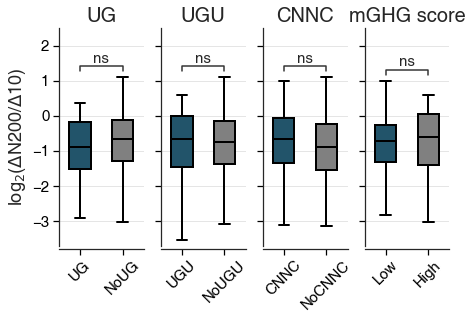

In [159]:
fig, ax = plt.subplots(1,4, figsize=(7,4), sharey=True)

### UG
ax_UG = sns.boxplot(x='UG', y = "log2FoldChange", data=DD_analysis, color='black', order=['UG','NoUG'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[0], width=0.5, fliersize=3.5, linewidth=2)
ax_UG.artists[0].set_facecolor("#22546a")
ax_UG.artists[1].set_facecolor("#808080")

ax[0].set_ylim(-3.7,2.5)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[0].set_xlabel("")
ax[0].set_title("UG", fontsize=20)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].spines['bottom'].set_position(('outward',3))

ax[0].tick_params(axis='x', colors='black')
ax[0].tick_params(axis='y', colors='black')

for label in ax[0].get_yticklabels():
    label.set_fontsize(15)
for label in ax[0].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

add_stat_annotation(ax[0], data=DD_analysis, x='UG', y ='log2FoldChange', \
                   box_pairs=[('UG','NoUG')], order=['UG','NoUG'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)


### UGU
ax_UGU = sns.boxplot(x='UGU', y = "log2FoldChange", data=DD_analysis, color='black', order=['UGU','NoUGU'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[1], width=0.5, fliersize=3.5, linewidth=2)
ax_UGU.artists[0].set_facecolor("#22546a")
ax_UGU.artists[1].set_facecolor("#808080")

ax[1].set_ylim(-3.7,2.5)
ax[1].set_ylabel("", fontsize=18)
ax[1].set_xlabel("")
ax[1].set_title("UGU", fontsize=20)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].spines['bottom'].set_position(('outward',3))

ax[1].tick_params(axis='x', colors='black')
ax[1].tick_params(axis='y', colors='black')

for label in ax[1].get_yticklabels():
    label.set_fontsize(15)
for label in ax[1].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

    
add_stat_annotation(ax[1], data=DD_analysis, x='UGU', y ='log2FoldChange', \
                   box_pairs=[('UGU','NoUGU')], order=['UGU','NoUGU'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)


### CNNC
ax_CNNC = sns.boxplot(x='CNNC', y = "log2FoldChange", data=DD_analysis, color='black', order=['CNNC','NoCNNC'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[2], width=0.5, fliersize=3.5, linewidth=2)
ax_CNNC.artists[0].set_facecolor("#22546a")
ax_CNNC.artists[1].set_facecolor("#808080")

ax[2].set_ylim(-3.7,2.5)
ax[2].set_ylabel("", fontsize=18)
ax[2].set_xlabel("")
ax[2].set_title("CNNC", fontsize=20)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].grid(axis='y', alpha=0.5)
ax[2].spines['bottom'].set_position(('outward',3))

ax[2].tick_params(axis='x', colors='black')
ax[2].tick_params(axis='y', colors='black')

for label in ax[2].get_yticklabels():
    label.set_fontsize(15)
for label in ax[2].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)
    
add_stat_annotation(ax[2], data=DD_analysis, x='CNNC', y ='log2FoldChange', \
                   box_pairs=[('CNNC','NoCNNC')], order=['CNNC','NoCNNC'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

### mGHG

tmp = DD_analysis[['log2FoldChange', 'mGHG_score']].copy()
tmp.dropna(inplace=True)
tmp["mGHG_group"] = pd.qcut(tmp['mGHG_score'], 3, labels = ['Low','Middle', 'High'])

ax_mGHG = sns.boxplot(x='mGHG_group', y = "log2FoldChange", data=tmp, color='black', order=['Low','High'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[3], width=0.5, fliersize=3.5, linewidth=2)
ax_mGHG.artists[0].set_facecolor("#22546a")
ax_mGHG.artists[1].set_facecolor("#808080")

ax[3].set_ylim(-3.7,2.5)
ax[3].set_ylabel("", fontsize=18)
ax[3].set_xlabel("")
ax[3].set_title("mGHG score", fontsize=20)

ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].grid(axis='y', alpha=0.5)
ax[3].spines['bottom'].set_position(('outward',3))

ax[3].tick_params(axis='x', colors='black')
ax[3].tick_params(axis='y', colors='black')

for label in ax[3].get_yticklabels():
    label.set_fontsize(15)
for label in ax[3].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)
    
add_stat_annotation(ax[3], data=tmp, x='mGHG_group', y ='log2FoldChange', \
                   box_pairs=[('Low','High')], order=['Low','High'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)




fig.show()
#plt.savefig("Results/Figures/210826-motif-all-box-HCT116.pdf", bbox_inches='tight')

### Clustered and Stand-alone

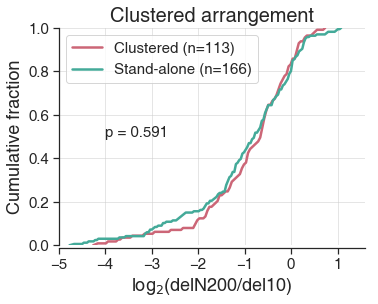

In [90]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

clustered = DD_analysis[DD_analysis["Clustered_2000"] == "clustered"]['log2FoldChange']
independent = DD_analysis[DD_analysis["Clustered_2000"] == "independent"]['log2FoldChange']

### evaluate the histogram
clustered_values, clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values, independent_base = np.histogram(independent, bins = len(independent))

### evaluate cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)

ax.plot(np.insert(clustered_base[:-1], 0, clustered_base[0]-0.1, axis = 0), \
        np.insert(clustered_cumulative,0,0, axis=0), label='Clustered '+'(n='+str(len(clustered))+")", \
        color = '#CC6677', linewidth=2.5)
ax.plot(np.insert(independent_base[:-1],0,independent_base[0]-0.1, axis=0),\
       np.insert(independent_cumulative,0,0,axis=0), label="Stand-alone " + "(n=" +str(len(independent))+")",\
       color='#44AA99', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Clustered arrangement", fontsize=20)
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(clustered, independent, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/210118-clustered-arrangement-HCT116.pdf", bbox_inches='tight')
del clustered, independent, clustered_values, clustered_base, independent_values, independent_base, clustered_cumulative, independent_cumulative

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

clustered v.s. independent: Mann-Whitney-Wilcoxon test two-sided, P_val=5.910e-01 U_stat=9.735e+03


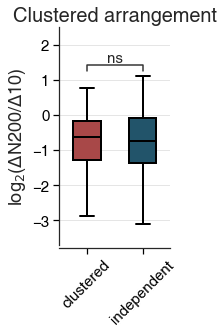

In [176]:
fig, ax = plt.subplots(1,1, figsize=(2,4), sharey=True)

ax = sns.boxplot(x='Clustered_2000', y = "log2FoldChange", data=DD_analysis, color='black', order=['clustered','independent'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax, width=0.5, fliersize=3.5, linewidth=2)
ax.artists[0].set_facecolor("#a84848")
ax.artists[1].set_facecolor("#22546a")

ax.set_ylim(-3.7,2.5)
ax.set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_xlabel("")
ax.set_title("Clustered arrangement", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

add_stat_annotation(ax, data=DD_analysis, x='Clustered_2000', y ='log2FoldChange', \
                   box_pairs=[('clustered','independent')], order=['clustered','independent'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

fig.show()
#plt.savefig("Results/Figures/210826-clustered-arrangement-box-HCT116.pdf", bbox_inches='tight')

In [168]:
add_stat_annotation?

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

First v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=9.049e-01 U_stat=5.030e+02
Middle v.s. Last: Mann-Whitney-Wilcoxon test two-sided, P_val=6.009e-01 U_stat=4.340e+02
First v.s. Last: Mann-Whitney-Wilcoxon test two-sided, P_val=7.048e-01 U_stat=1.008e+03


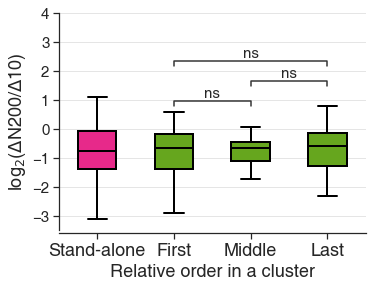

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

ax = sns.boxplot(x='cluster_rel_label', y = "log2FoldChange", data=DD_analysis, color='black', \
                 order=['Stand-alone', 'First','Middle','Last'], boxprops={'facecolor': 'None'}, \
                 ax=ax, width=0.5, showfliers = False, linewidth=2)
ax.artists[0].set_facecolor("#e7298a")
ax.artists[1].set_facecolor("#66a61e")
ax.artists[2].set_facecolor("#66a61e")
ax.artists[3].set_facecolor("#66a61e")



ax.set_ylim(-3.5,4)
ax.set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_xlabel("Relative order in a cluster", fontsize=18)
#ax[0].set_title("UG", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(18)
    
add_stat_annotation(ax, data=DD_analysis, x='cluster_rel_label', y ='log2FoldChange', \
                   box_pairs=[("First", "Middle"), ("Middle", "Last"), ("First", "Last")], order=['Stand-alone', 'First','Middle','Last'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)
            
# line_offset_to_box=0.2, line_offset=0.1, line_height=0.05, text_offset=8
#p0 = mannwhitneyu(DD_analysis[C_filtered_2000["cluster_rel_label"] == "First"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Middle"]["log2FoldChange"],alternative = 'two-sided')[1]
#p1 = mannwhitneyu(C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "First"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Last"]["log2FoldChange"],alternative = 'two-sided')[1]
#p2 = mannwhitneyu(C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Middle"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Last"]["log2FoldChange"],alternative = 'two-sided')[1]

#ax.text(0.25,-3.2,'First vs. Middle p=%.3f'%p0,  fontsize=15)
#ax.text(0.25,-3.5,'First vs. Last p=%.3f'%p1,  fontsize=15)
#ax.text(0.25,-3.8,'Middle vs. Last p=%.3f'%p2,  fontsize=15)

fig.show()

#plt.savefig("Results/Figures/210225-cluster-all-HCT116.pdf", bbox_inches='tight')

### Genomic location: Exonic v.s. Intronic

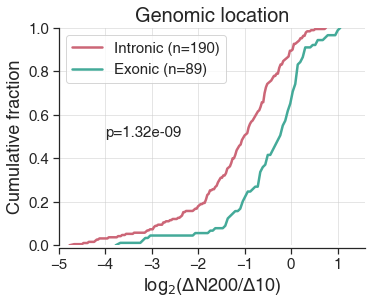

In [64]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

intronic = DD_analysis[DD_analysis["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = DD_analysis[DD_analysis["Exon_Intron"] == "exonic"]["log2FoldChange"]

intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))

intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)


ax.plot(np.insert(intronic_base[:-1],0,intronic_base[0]-0.1,axis=0),\
        np.insert(intronic_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic))+")",\
        color='#CC6677', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1,axis=0),\
        np.insert(exonic_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic))+")",\
        color='#44AA99', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Genomic location", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax.text(-4,0.5,'p=%.2e'%p0,  fontsize=15)

fig.show()

#plt.savefig("Results/Figures/210307-exon-intron-cumulative-HCT116.pdf", bbox_inches='tight')

intronic v.s. exonic: Mann-Whitney-Wilcoxon test two-sided, P_val=1.322e-09 U_stat=4.645e+03


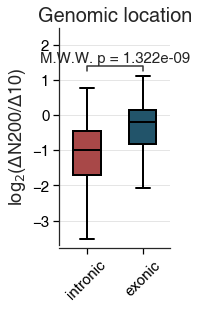

In [177]:
fig, ax = plt.subplots(1,1, figsize=(2,4), sharey=True)

ax = sns.boxplot(x='Exon_Intron', y = "log2FoldChange", data=DD_analysis, color='black', order=['intronic','exonic'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax, width=0.5, fliersize=3.5, linewidth=2)
ax.artists[0].set_facecolor("#a84848")
ax.artists[1].set_facecolor("#22546a")

ax.set_ylim(-3.7,2.5)
ax.set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_xlabel("")
ax.set_title("Genomic location", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

add_stat_annotation(ax, data=DD_analysis, x='Exon_Intron', y ='log2FoldChange', \
                   box_pairs=[('intronic','exonic')], order=['intronic','exonic'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='full', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

fig.show()
#plt.savefig("Results/Figures/210826-exon-intron-box-HCT116.pdf", bbox_inches='tight')

Among stand-alone miRNAs

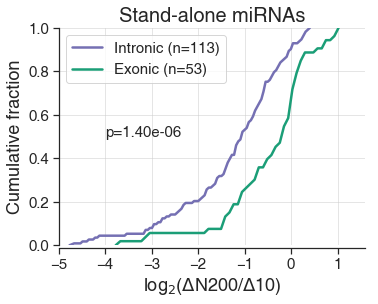

In [76]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

intronic_indep = DD_analysis[(DD_analysis["Exon_Intron"] == "intronic") & (DD_analysis["Clustered_2000"] == 'independent')]["log2FoldChange"]
exonic_indep = DD_analysis[(DD_analysis["Exon_Intron"] == "exonic") & (DD_analysis["Clustered_2000"] == 'independent')]["log2FoldChange"]

intronic_indep_values , intronic_indep_base = np.histogram(intronic_indep, bins = len(intronic_indep))
exonic_indep_values , exonic_indep_base = np.histogram(exonic_indep, bins = len(exonic_indep))

intronic_indep_cumulative = np.cumsum(intronic_indep_values) / np.sum(intronic_indep_values)
exonic_indep_cumulative = np.cumsum(exonic_indep_values) / np.sum(exonic_indep_values)


ax.plot(np.insert(intronic_indep_base[:-1],0,intronic_indep_base[0]-0.1,axis=0),\
        np.insert(intronic_indep_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_indep))+")",\
        color='#7570b3', linewidth=2.5)
ax.plot(np.insert(exonic_indep_base[:-1],0,exonic_indep_base[0]-0.1,axis=0),\
        np.insert(exonic_indep_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_indep))+")",\
        color='#1b9e77', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Stand-alone miRNAs", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(intronic_indep, exonic_indep, alternative='two-sided')[1] 
ax.text(-4,0.5,'p=%.2e'%p0,  fontsize=15)

fig.show()

#plt.savefig("Results/Figures/201214-Standalone-HCT116.pdf", bbox_inches='tight')

Among clustered miRNAs

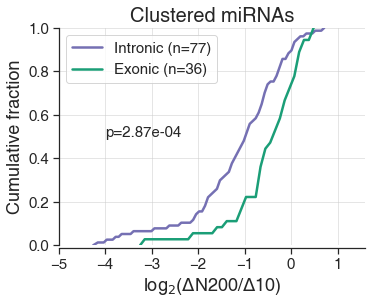

In [79]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

intronic_clustered = DD_analysis[(DD_analysis["Exon_Intron"] == "intronic") & (DD_analysis["Clustered_2000"] == 'clustered')]["log2FoldChange"]
exonic_clustered = DD_analysis[(DD_analysis["Exon_Intron"] == "exonic") & (DD_analysis["Clustered_2000"] == 'clustered')]["log2FoldChange"]

intronic_clustered_values , intronic_clustered_base = np.histogram(intronic_clustered, bins = len(intronic_clustered))
exonic_clustered_values , exonic_clustered_base = np.histogram(exonic_clustered, bins = len(exonic_clustered))

intronic_clustered_cumulative = np.cumsum(intronic_clustered_values) / np.sum(intronic_clustered_values)
exonic_clustered_cumulative = np.cumsum(exonic_clustered_values) / np.sum(exonic_clustered_values)


ax.plot(np.insert(intronic_clustered_base[:-1],0,intronic_clustered_base[0]-0.1,axis=0),\
        np.insert(intronic_clustered_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_clustered))+")",\
        color='#7570b3', linewidth=2.5)
ax.plot(np.insert(exonic_clustered_base[:-1],0,exonic_clustered_base[0]-0.1,axis=0),\
        np.insert(exonic_clustered_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_clustered))+")",\
        color='#1b9e77', linewidth=2.5)


ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Clustered miRNAs", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(intronic_clustered, exonic_clustered, alternative='two-sided')[1] 
ax.text(-4,0.5,'p=%.2e'%p0,  fontsize=15)

fig.show()

#plt.savefig("Results/Figures/201214-Clustered-HCT116.pdf", bbox_inches='tight')

Check point

In [81]:
#DD_analysis.to_csv('210308_HCT116_DD_analysis.csv')

In [96]:
DD_filtered.head()

,baseMean,log2FoldChange,stat,pvalue,padj,curated DROSHA dependency (HCT116),pri-miRNA,Chr,pri Start,pri End,strand,Clustered,Locus,Exon_Intron,HostGene,Direction
mature,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,DROSHA-dependent,hsa-let-7a-2,chr11,122146522.0,122146593.0,-,clustered,intergenic,intergenic,0,0
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,DROSHA-dependent,hsa-let-7b,chr22,46113686.0,46113768.0,+,clustered,intergenic,intergenic,0,0
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,DROSHA-dependent,hsa-let-7b,chr22,46113686.0,46113768.0,+,clustered,intergenic,intergenic,0,0
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,DROSHA-dependent,hsa-let-7c,chr21,16539828.0,16539911.0,+,clustered,intergenic,intergenic,0,0
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,DROSHA-dependent,hsa-let-7d,chr9,94178834.0,94178920.0,+,clustered,intergenic,intergenic,0,0


### RNA society 2021 or fig 5 f/s version

- Change log2 (delN200/del10) -> log2 (del10/delN200)

In [105]:
RNA2021 = DD_analysis.copy()
RNA2021.head()

,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,47,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,47,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,54,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.0535,independent,-3,-3,-3,0.75,Stand-alone,intronic


In [106]:
RNA2021['log2FoldChange'] = -RNA2021['log2FoldChange']

In [110]:
RNA2021.head()

,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,47,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,47,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,54,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.0535,independent,-3,-3,-3,0.75,Stand-alone,intronic


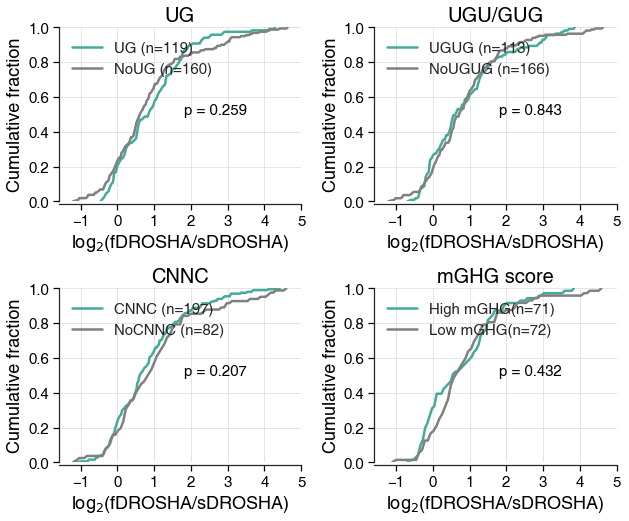

In [109]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

#################### ax[0,0] : UG ####################

UG = RNA2021[RNA2021["UG"] == "UG"]['log2FoldChange']
NoUG = RNA2021[RNA2021["UG"] == "NoUG"]['log2FoldChange']

### evaluate the histogram
UG_values, UG_base = np.histogram(UG, bins = len(UG))
NoUG_values, NoUG_base = np.histogram(NoUG, bins = len(NoUG))

### evaluate cumulative
UG_cumulative = np.cumsum(UG_values) / np.sum(UG_values)
NoUG_cumulative = np.cumsum(NoUG_values) / np.sum(NoUG_values)

ax[0,0].plot(np.insert(UG_base[:-1], 0, UG_base[0]-0.1, axis = 0), \
        np.insert(UG_cumulative,0,0, axis=0), label='UG '+'(n='+str(len(UG))+")", \
        color = '#44AA99', linewidth=2.5)
ax[0,0].plot(np.insert(NoUG_base[:-1],0,NoUG_base[0]-0.1, axis=0),\
       np.insert(NoUG_cumulative,0,0,axis=0), label="NoUG " + "(n=" +str(len(NoUG))+")",\
       color='#808080', linewidth=2.5)

ax[0,0].set_xlim(-1.6,5)
ax[0,0].set_ylim(0,1)
ax[0,0].set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax[0,0].set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax[0,0].set_title("UG", fontsize=20, color='black')
ax[0,0].legend(frameon=False, loc="upper left", fontsize=15)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].grid(axis='x', alpha=0.5)
ax[0,0].grid(axis='y', alpha=0.5)
ax[0,0].spines['bottom'].set_position(('outward',3))

for label in (ax[0,0].get_xticklabels() + ax[0,0].get_yticklabels()):
    label.set_fontsize(15)
ax[0,0].tick_params(axis='x', colors='black')
ax[0,0].tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(UG, NoUG, alternative = 'two-sided')[1]
ax[0,0].text(1.8,0.5, 'p = %.3f'%p0, fontsize=15, color='black')

del UG, NoUG, UG_values, UG_base, NoUG_values, NoUG_base, UG_cumulative, NoUG_cumulative


#################### ax[0,1] : UGU ####################

UGU = RNA2021[RNA2021["UGU"] == "UGU"]['log2FoldChange']
NoUGU = RNA2021[RNA2021["UGU"] == "NoUGU"]['log2FoldChange']

### evaluate the histogram
UGU_values, UGU_base = np.histogram(UGU, bins = len(UGU))
NoUGU_values, NoUGU_base = np.histogram(NoUGU, bins = len(NoUGU))

### evaluate cumulative
UGU_cumulative = np.cumsum(UGU_values) / np.sum(UGU_values)
NoUGU_cumulative = np.cumsum(NoUGU_values) / np.sum(NoUGU_values)

ax[0,1].plot(np.insert(UGU_base[:-1], 0, UGU_base[0]-0.1, axis = 0), \
        np.insert(UGU_cumulative,0,0, axis=0), label='UGUG '+'(n='+str(len(UGU))+")", \
        color = '#44AA99', linewidth=2.5)
ax[0,1].plot(np.insert(NoUGU_base[:-1],0,NoUGU_base[0]-0.1, axis=0),\
       np.insert(NoUGU_cumulative,0,0,axis=0), label="NoUGUG " + "(n=" +str(len(NoUGU))+")",\
       color='#808080', linewidth=2.5)

ax[0,1].set_xlim(-1.6,5)
ax[0,1].set_ylim(0,1)
ax[0,1].set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax[0,1].set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax[0,1].set_title("UGU/GUG", fontsize=20, color='black')
ax[0,1].legend(frameon=False, loc="upper left", fontsize=15)

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].grid(axis='x', alpha=0.5)
ax[0,1].grid(axis='y', alpha=0.5)
ax[0,1].spines['bottom'].set_position(('outward',3))

for label in (ax[0,1].get_xticklabels() + ax[0,1].get_yticklabels()):
    label.set_fontsize(15)
ax[0,1].tick_params(axis='x', colors='black')
ax[0,1].tick_params(axis='y', colors='black')
    
p1 = mannwhitneyu(UGU, NoUGU, alternative = 'two-sided')[1]
ax[0,1].text(1.8,0.5, 'p = %.3f'%p1, fontsize=15, color='black')

del UGU, NoUGU, UGU_values, UGU_base, NoUGU_values, NoUGU_base, UGU_cumulative, NoUGU_cumulative

#################### ax[1,0] : CNNC ####################

CNNC = RNA2021[RNA2021["CNNC"] == "CNNC"]['log2FoldChange']
NoCNNC = RNA2021[RNA2021["CNNC"] == "NoCNNC"]['log2FoldChange']

### evaluate the histogram
CNNC_values, CNNC_base = np.histogram(CNNC, bins = len(CNNC))
NoCNNC_values, NoCNNC_base = np.histogram(NoCNNC, bins = len(NoCNNC))

### evaluate cumulative
CNNC_cumulative = np.cumsum(CNNC_values) / np.sum(CNNC_values)
NoCNNC_cumulative = np.cumsum(NoCNNC_values) / np.sum(NoCNNC_values)

ax[1,0].plot(np.insert(CNNC_base[:-1], 0, CNNC_base[0]-0.1, axis = 0), \
        np.insert(CNNC_cumulative,0,0, axis=0), label='CNNC '+'(n='+str(len(CNNC))+")", \
        color = '#44AA99', linewidth=2.5)
ax[1,0].plot(np.insert(NoCNNC_base[:-1],0,NoCNNC_base[0]-0.1, axis=0),\
       np.insert(NoCNNC_cumulative,0,0,axis=0), label="NoCNNC " + "(n=" +str(len(NoCNNC))+")",\
       color='#808080', linewidth=2.5)

ax[1,0].set_xlim(-1.6,5)
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax[1,0].set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax[1,0].set_title("CNNC", fontsize=20, color='black')
ax[1,0].legend(frameon=False, loc="upper left", fontsize=15)

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].grid(axis='x', alpha=0.5)
ax[1,0].grid(axis='y', alpha=0.5)
ax[1,0].spines['bottom'].set_position(('outward',3))

for label in (ax[1,0].get_xticklabels() + ax[1,0].get_yticklabels()):
    label.set_fontsize(15)
ax[1,0].tick_params(axis='x', colors='black')
ax[1,0].tick_params(axis='y', colors='black')

p2 = mannwhitneyu(CNNC, NoCNNC, alternative = 'two-sided')[1]
ax[1,0].text(1.8,0.5, 'p = %.3f'%p2, fontsize=15, color='black')

del CNNC, NoCNNC, CNNC_values, CNNC_base, NoCNNC_values, NoCNNC_base, CNNC_cumulative, NoCNNC_cumulative

#################### ax[1,1]: mGHG ####################

tmp = RNA2021[['log2FoldChange', 'mGHG_score']].copy()
tmp.dropna(inplace=True)
tmp["mGHG_group"] = pd.qcut(tmp['mGHG_score'], 3, labels = ['Low','Middle', 'High'])


mGHG_high = tmp[tmp["mGHG_group"] == "High"]["log2FoldChange"]
mGHG_low = tmp[tmp["mGHG_group"] == "Low"]["log2FoldChange"]

### evaluate the histogram
mGHG_high_values, mGHG_high_base = np.histogram(mGHG_high, bins = len(mGHG_high))
mGHG_low_values, mGHG_low_base = np.histogram(mGHG_low, bins = len(mGHG_low))

### evaluate cumulative
mGHG_high_cumulative = np.cumsum(mGHG_high_values) / np.sum(mGHG_high_values)
mGHG_low_cumulative = np.cumsum(mGHG_low_values) / np.sum(mGHG_low_values)

ax[1,1].plot(np.insert(mGHG_high_base[:-1], 0, mGHG_high_base[0]-0.1, axis = 0), \
        np.insert(mGHG_high_cumulative,0,0, axis=0), label='High mGHG'+'(n='+str(len(mGHG_high))+")", \
        color = '#44AA99', linewidth=2.5)
ax[1,1].plot(np.insert(mGHG_low_base[:-1],0,mGHG_low_base[0]-0.1, axis=0),\
       np.insert(mGHG_low_cumulative,0,0,axis=0), label="Low mGHG" + "(n=" +str(len(mGHG_low))+")",\
       color='#808080', linewidth=2.5)

ax[1,1].set_xlim(-1.6,5)
ax[1,1].set_ylim(0,1)
ax[1,1].set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax[1,1].set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax[1,1].set_title("mGHG score", fontsize=20, color='black')
ax[1,1].legend(frameon=False, loc="upper left", fontsize=15)

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].grid(axis='x', alpha=0.5)
ax[1,1].grid(axis='y', alpha=0.5)
ax[1,1].spines['bottom'].set_position(('outward',3))

for label in (ax[1,1].get_xticklabels() + ax[1,1].get_yticklabels()):
    label.set_fontsize(15)
ax[1,1].tick_params(axis='x', colors='black')
ax[1,1].tick_params(axis='y', colors='black')
    
p3 = mannwhitneyu(mGHG_high, mGHG_low, alternative = 'two-sided')[1]
ax[1,1].text(1.8,0.5, 'p = %.3f'%p3, fontsize=15, color='black')

del mGHG_high, mGHG_low, mGHG_high_values, mGHG_high_base, mGHG_low_values, mGHG_low_base, mGHG_high_cumulative, mGHG_low_cumulative


fig.show()
#plt.savefig("Results/Figures/210518-RNA2021-motif-all-cum-HCT116.pdf", bbox_inches='tight')

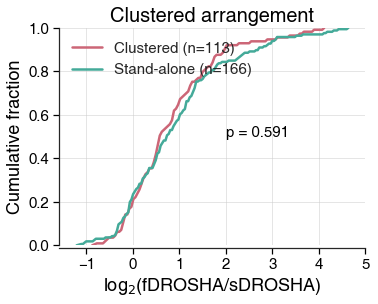

In [111]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

clustered = RNA2021[RNA2021["Clustered_2000"] == "clustered"]['log2FoldChange']
independent = RNA2021[RNA2021["Clustered_2000"] == "independent"]['log2FoldChange']

### evaluate the histogram
clustered_values, clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values, independent_base = np.histogram(independent, bins = len(independent))

### evaluate cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)

ax.plot(np.insert(clustered_base[:-1], 0, clustered_base[0]-0.1, axis = 0), \
        np.insert(clustered_cumulative,0,0, axis=0), label='Clustered '+'(n='+str(len(clustered))+")", \
        color = '#CC6677', linewidth=2.5)
ax.plot(np.insert(independent_base[:-1],0,independent_base[0]-0.1, axis=0),\
       np.insert(independent_cumulative,0,0,axis=0), label="Stand-alone " + "(n=" +str(len(independent))+")",\
       color='#44AA99', linewidth=2.5)

ax.set_xlim(-1.6,5)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("Clustered arrangement", fontsize=20, color='black')
ax.legend(loc="upper left", fontsize=15, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(clustered, independent, alternative = 'two-sided')[1]
ax.text(2,0.5, 'p = %.3f'%p0, fontsize=15, color='black')
fig.show()

#plt.savefig("Results/Figures/210518-RNA2021-clustered-arrangement-HCT116.pdf", bbox_inches='tight')
del clustered, independent, clustered_values, clustered_base, independent_values, independent_base, clustered_cumulative, independent_cumulative

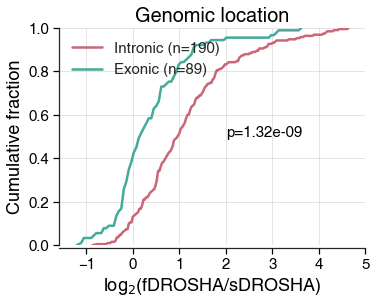

In [112]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

intronic = RNA2021[RNA2021["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = RNA2021[RNA2021["Exon_Intron"] == "exonic"]["log2FoldChange"]

intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))

intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)


ax.plot(np.insert(intronic_base[:-1],0,intronic_base[0]-0.1,axis=0),\
        np.insert(intronic_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic))+")",\
        color='#CC6677', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1,axis=0),\
        np.insert(exonic_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic))+")",\
        color='#44AA99', linewidth=2.5)

ax.set_xlim(-1.6,5)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("Genomic location", fontsize=20,color='black')
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=False, loc='upper left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax.text(2,0.5,'p=%.2e'%p0,  fontsize=15, color='black')

fig.show()

#plt.savefig("Results/Figures/210518-RNA2021-exon-intron-cumulative-HCT116.pdf", bbox_inches='tight')

### Related to Prof's question

##### Higher abundance cutoff

In [66]:
print(DD_analysis.shape)
DD_analysis.head()

(279, 17)


,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,50,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,50,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,82,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.0535,independent,-3,-3,-3,0.75,Stand-alone,intronic


In [64]:
top200 = DD_analysis.sort_values(by='baseMean', ascending=False).iloc[:200]
top100 = DD_analysis.sort_values(by='baseMean', ascending=False).iloc[:100]

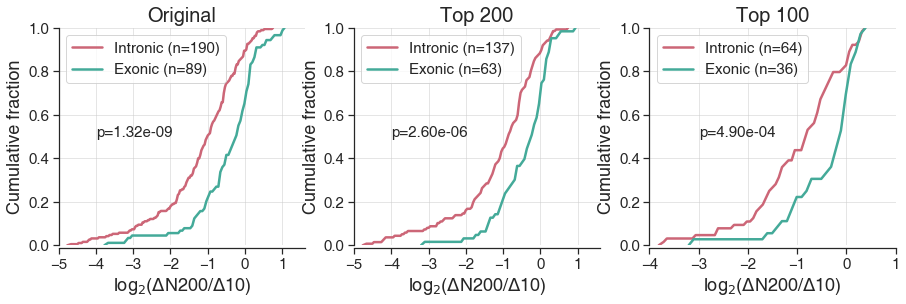

In [85]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

intronic = DD_analysis[DD_analysis["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = DD_analysis[DD_analysis["Exon_Intron"] == "exonic"]["log2FoldChange"]

intronic_200 = top200[top200["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic_200 = top200[top200["Exon_Intron"] == "exonic"]["log2FoldChange"]

intronic_100 = top100[top100["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic_100 = top100[top100["Exon_Intron"] == "exonic"]["log2FoldChange"]

intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))
intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)

intronic_200_values , intronic_200_base = np.histogram(intronic_200, bins = len(intronic_200))
exonic_200_values , exonic_200_base = np.histogram(exonic_200, bins = len(exonic_200))
intronic_200_cumulative = np.cumsum(intronic_200_values) / np.sum(intronic_200_values)
exonic_200_cumulative = np.cumsum(exonic_200_values) / np.sum(exonic_200_values)

intronic_100_values , intronic_100_base = np.histogram(intronic_100, bins = len(intronic_100))
exonic_100_values , exonic_100_base = np.histogram(exonic_100, bins = len(exonic_100))
intronic_100_cumulative = np.cumsum(intronic_100_values) / np.sum(intronic_100_values)
exonic_100_cumulative = np.cumsum(exonic_100_values) / np.sum(exonic_100_values)


ax[0].plot(np.insert(intronic_base[:-1],0,intronic_base[0]-0.1,axis=0),\
        np.insert(intronic_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic))+")",\
        color='#CC6677', linewidth=2.5)
ax[0].plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1,axis=0),\
        np.insert(exonic_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic))+")",\
        color='#44AA99', linewidth=2.5)

ax[0].set_xlim(-5,1.6)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[0].set_ylabel("Cumulative fraction", fontsize=18)
ax[0].set_title("Original", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax[0].legend(frameon=True, loc='upper left', fontsize=15)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='x', alpha=0.5)
ax[0].grid(axis='y', alpha=0.5)
ax[0].spines['bottom'].set_position(('outward',3))

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax[0].text(-4,0.5,'p=%.2e'%p0,  fontsize=15)


ax[1].plot(np.insert(intronic_200_base[:-1],0,intronic_200_base[0]-0.1,axis=0),\
        np.insert(intronic_200_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_200))+")",\
        color='#CC6677', linewidth=2.5)
ax[1].plot(np.insert(exonic_200_base[:-1],0,exonic_200_base[0]-0.1,axis=0),\
        np.insert(exonic_200_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_200))+")",\
        color='#44AA99', linewidth=2.5)

ax[1].set_xlim(-5,1.6)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[1].set_ylabel("Cumulative fraction", fontsize=18)
ax[1].set_title("Top 200", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax[1].legend(frameon=True, loc='upper left', fontsize=15)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='x', alpha=0.5)
ax[1].grid(axis='y', alpha=0.5)
ax[1].spines['bottom'].set_position(('outward',3))

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)
    
p1 = mannwhitneyu(intronic_200, exonic_200, alternative='two-sided')[1] 
ax[1].text(-4,0.5,'p=%.2e'%p1,  fontsize=15)


ax[2].plot(np.insert(intronic_100_base[:-1],0,intronic_100_base[0]-0.1,axis=0),\
        np.insert(intronic_100_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_100))+")",\
        color='#CC6677', linewidth=2.5)
ax[2].plot(np.insert(exonic_100_base[:-1],0,exonic_100_base[0]-0.1,axis=0),\
        np.insert(exonic_100_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_100))+")",\
        color='#44AA99', linewidth=2.5)

ax[2].set_xlim(-4,1)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[2].set_ylabel("Cumulative fraction", fontsize=18)
ax[2].set_title("Top 100", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax[2].legend(frameon=True, loc='upper left', fontsize=15)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].grid(axis='x', alpha=0.5)
ax[2].grid(axis='y', alpha=0.5)
ax[2].spines['bottom'].set_position(('outward',3))

for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
    label.set_fontsize(15)
    
p2 = mannwhitneyu(intronic_100, exonic_100, alternative='two-sided')[1] 
ax[2].text(-3,0.5,'p=%.2e'%p2,  fontsize=15)

fig.show()

##### Compared clustered v.s. stand-alone among intronics

In [86]:
DD_analysis.head()

,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,50,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,50,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,82,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.0535,independent,-3,-3,-3,0.75,Stand-alone,intronic


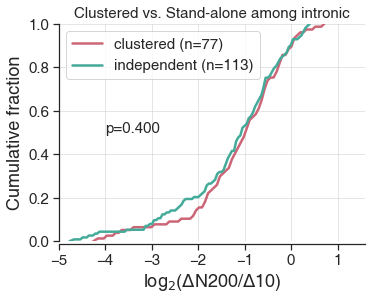

In [100]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

clustered = DD_analysis[(DD_analysis["Exon_Intron"] == "intronic") & (DD_analysis["Clustered_2000"] == "clustered")]["log2FoldChange"]
independent = DD_analysis[(DD_analysis["Exon_Intron"] == "intronic") & (DD_analysis["Clustered_2000"] == "independent")]["log2FoldChange"]


clustered_values , clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values , independent_base = np.histogram(independent, bins = len(independent))

clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)


ax.plot(np.insert(clustered_base[:-1],0,clustered_base[0]-0.1,axis=0),\
        np.insert(clustered_cumulative,0,0,axis=0),label="clustered "+"(n="+str(len(clustered))+")",\
        color='#CC6677', linewidth=2.5)
ax.plot(np.insert(independent_base[:-1],0,independent_base[0]-0.1,axis=0),\
        np.insert(independent_cumulative,0,0,axis=0),label="independent "+"(n="+str(len(independent))+")",\
        color='#44AA99', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Clustered vs. Stand-alone among intronic", fontsize=15)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(clustered, independent, alternative='two-sided')[1] 
ax.text(-4,0.5,'p=%.3f'%p0,  fontsize=15)

fig.show()

##### Cleavage efficiency; Cleavage homogeneity vs. P-rich domain dependency

In [6]:
DD_analysis = pd.read_csv('210308_HCT116_DD_analysis.csv').set_index('mature')
DD_analysis.head()

,baseMean,log2FoldChange,stat,pvalue,padj,pri-miRNA,UG,UGU,CNNC,mGHG_score,Clustered_2000,cluster_order,cluster_id,cluster_len,cluster_rel_order,cluster_rel_label,Exon_Intron
mature,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,-2.165859,3.032197e-02,6.683580e-02,hsa-let-7a-2,UG,NoUGU,CNNC,NaN,independent,-3,-3,-3,0.75,Stand-alone,intronic
hsa-let-7b-3p,113.500150,-0.583679,-2.091957,3.644239e-02,7.642490e-02,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,14,3,1.00,Last,exonic
hsa-let-7b-5p,3288.216511,-0.136267,-0.518374,6.041975e-01,6.918580e-01,hsa-let-7b,NoUG,NoUGU,CNNC,NaN,clustered,2,14,3,1.00,Last,exonic
hsa-let-7c-5p,86.709270,-0.235136,-0.698768,4.846967e-01,5.822707e-01,hsa-let-7c,UG,NoUGU,CNNC,NaN,clustered,1,64,2,1.00,Last,intronic
hsa-let-7d-3p,205.664358,-2.068898,-8.038121,9.122686e-16,4.782894e-14,hsa-let-7d,UG,NoUGU,CNNC,40.053494,independent,-3,-3,-3,0.75,Stand-alone,intronic


In [7]:
only_MP = pd.read_excel('from_KJ_SC/220308_KJ_paper_MP_only.xlsx', engine = 'openpyxl')[["Pri-miRNA", "Cleavage Efficiency", "Cleavage Homogeneity"]].set_index("Pri-miRNA")
with_SRSF = pd.read_excel('from_KJ_SC/220308_KJ_paper_SRSF3.xlsx', engine = 'openpyxl')[["Pri-miRNA", "Cleavage Efficiency", "Cleavage Homogeneity"]].set_index("Pri-miRNA")

In [8]:
KJ_table = only_MP.join(with_SRSF, how = 'inner', lsuffix = '_MP', rsuffix = '_SRSF')
KJ_table.head()

,Cleavage Efficiency_MP,Cleavage Homogeneity_MP,Cleavage Efficiency_SRSF,Cleavage Homogeneity_SRSF
Pri-miRNA,,,,
hsa-let-7a-1,4.051311,0.882549,6.380507,0.870736
hsa-let-7a-2,3.272476,0.787974,5.804210,0.767239
hsa-let-7a-3,1.761117,0.499679,3.507877,0.636835
hsa-let-7b,3.022173,0.767644,5.453751,0.753999
hsa-let-7c,0.000000,0.119761,4.632084,0.666916


In [9]:
vs_KJ = DD_analysis.join(KJ_table, on ='pri-miRNA', how = 'inner')[['log2FoldChange', 'Exon_Intron','Cleavage Efficiency_MP', 'Cleavage Homogeneity_MP', 'Cleavage Efficiency_SRSF', 'Cleavage Homogeneity_SRSF']]
vs_KJ["CE_MP_group"] = pd.qcut(vs_KJ["Cleavage Efficiency_MP"], 3, labels=['Low', 'Middle','High'])
vs_KJ["CH_MP_group"] = pd.qcut(vs_KJ["Cleavage Homogeneity_MP"], 3, labels=['Low', 'Middle','High'])
vs_KJ["CE_SRSF_group"] = pd.qcut(vs_KJ["Cleavage Efficiency_SRSF"], 3, labels=['Low', 'Middle','High'])
vs_KJ["CH_SRSF_group"] = pd.qcut(vs_KJ["Cleavage Homogeneity_MP"], 3, labels=['Low', 'Middle','High'])

vs_KJ.head()


,log2FoldChange,Exon_Intron,Cleavage Efficiency_MP,Cleavage Homogeneity_MP,Cleavage Efficiency_SRSF,Cleavage Homogeneity_SRSF,CE_MP_group,CH_MP_group,CE_SRSF_group,CH_SRSF_group
mature,,,,,,,,,,
hsa-let-7a-2-3p,-0.901333,intronic,3.272476,0.787974,5.804210,0.767239,High,High,High,High
hsa-let-7b-3p,-0.583679,exonic,3.022173,0.767644,5.453751,0.753999,Middle,High,Middle,High
hsa-let-7b-5p,-0.136267,exonic,3.022173,0.767644,5.453751,0.753999,Middle,High,Middle,High
hsa-let-7c-5p,-0.235136,intronic,0.000000,0.119761,4.632084,0.666916,Low,Low,Middle,Low
hsa-let-7d-3p,-2.068898,intronic,2.908662,0.492728,5.892324,0.802592,Middle,Middle,High,Middle


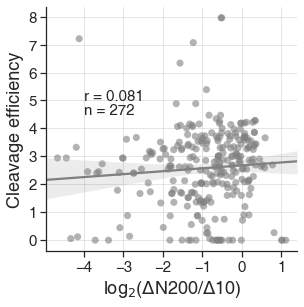

In [25]:
fig, ax = plt.subplots(1,1, figsize=(4.5,4.5))

#ax.set_xlim(-5,1.3)
#ax.set_ylim(-0.5,8.2)

sns.regplot(x='log2FoldChange', y='Cleavage Efficiency_MP', data = vs_KJ, ax = ax, truncate=False, \
           color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':'none'})

r = stats.pearsonr(vs_KJ["Cleavage Efficiency_MP"], vs_KJ["log2FoldChange"])[0]
ax.text(-4,5, 'r = %.3f'%r, fontsize = 15)
ax.text(-4,4.5, 'n = ' + str((len(vs_KJ))), fontsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.set_ylabel("Cleavage efficiency", fontsize=18)
ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
# ax[0].set_title("HCT116", fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
#plt.savefig("Results/Figures/221102-PRD-dep-CE-scatter-HCT116.svg", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (4.5,4.5))

ax[0].set_xlim(-0.5,8.5)
ax[0].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Efficiency_MP", y="log2FoldChange", data=vs_KJ_intron, ax = ax[0], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Efficiency_MP"], vs_KJ_intron["log2FoldChange"])[0]
ax[0].text(6,-3, 'r = %.3f'%r0, fontsize = 15)
ax[0].text(6,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].set_xlabel("Cleavage Efficiency (only MP)", fontsize=18)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
# ax[0].set_title("HCT116", fontsize=20)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

ax[1].set_xlim(-0.1,1.1)
ax[1].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Homogeneity_MP", y="log2FoldChange", data=vs_KJ_intron, ax = ax[1], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Homogeneity_MP"], vs_KJ_intron["log2FoldChange"])[0]
ax[1].text(0.7,-3, 'r = %.3f'%r0, fontsize = 15)
ax[1].text(0.7,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].set_xlabel("Cleavage Homogeneity (only MP)", fontsize=18)
ax[1].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
#ax[1].set_title("HCT116", fontsize=20)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

plt.suptitle("Only MP (Intronic)", fontsize=20)
# #plt.savefig("../../200521_HCT116_analysis/Results/Figures/210129-SAFB12-HEK293T-HCT116-HEK293E.pdf", bbox_inches='tight')

In [186]:
vs_KJ_intron = vs_KJ[vs_KJ["Exon_Intron"] == 'intronic']
vs_KJ_intron["CE_MP_group"] = pd.qcut(vs_KJ_intron["Cleavage Efficiency_MP"], 3, labels=['Low', 'Middle','High'])
vs_KJ_intron["CH_MP_group"] = pd.qcut(vs_KJ_intron["Cleavage Homogeneity_MP"], 3, labels=['Low', 'Middle','High'])
vs_KJ_intron["CE_SRSF_group"] = pd.qcut(vs_KJ_intron["Cleavage Efficiency_SRSF"], 3, labels=['Low', 'Middle','High'])
vs_KJ_intron["CH_SRSF_group"] = pd.qcut(vs_KJ_intron["Cleavage Homogeneity_MP"], 3, labels=['Low', 'Middle','High'])

/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Text(0.5, 0.98, 'Only MP (Intronic)')

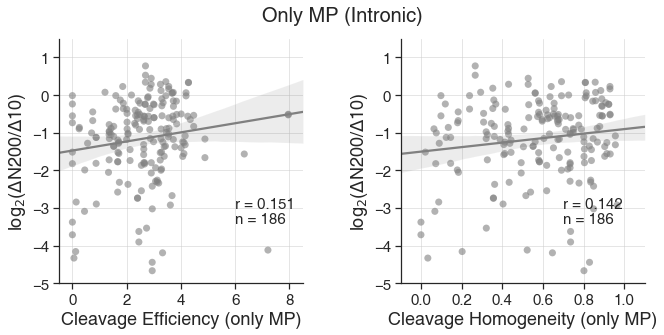

In [192]:
fig, ax = plt.subplots(1,2, figsize = (10.5,4.5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax[0].set_xlim(-0.5,8.5)
ax[0].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Efficiency_MP", y="log2FoldChange", data=vs_KJ_intron, ax = ax[0], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Efficiency_MP"], vs_KJ_intron["log2FoldChange"])[0]
ax[0].text(6,-3, 'r = %.3f'%r0, fontsize = 15)
ax[0].text(6,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].set_xlabel("Cleavage Efficiency (only MP)", fontsize=18)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
# ax[0].set_title("HCT116", fontsize=20)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

ax[1].set_xlim(-0.1,1.1)
ax[1].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Homogeneity_MP", y="log2FoldChange", data=vs_KJ_intron, ax = ax[1], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Homogeneity_MP"], vs_KJ_intron["log2FoldChange"])[0]
ax[1].text(0.7,-3, 'r = %.3f'%r0, fontsize = 15)
ax[1].text(0.7,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].set_xlabel("Cleavage Homogeneity (only MP)", fontsize=18)
ax[1].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
#ax[1].set_title("HCT116", fontsize=20)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

plt.suptitle("Only MP (Intronic)", fontsize=20)
# #plt.savefig("../../200521_HCT116_analysis/Results/Figures/210129-SAFB12-HEK293T-HCT116-HEK293E.pdf", bbox_inches='tight')

Text(0.5, 0.98, 'With SRSF3 (Intronic)')

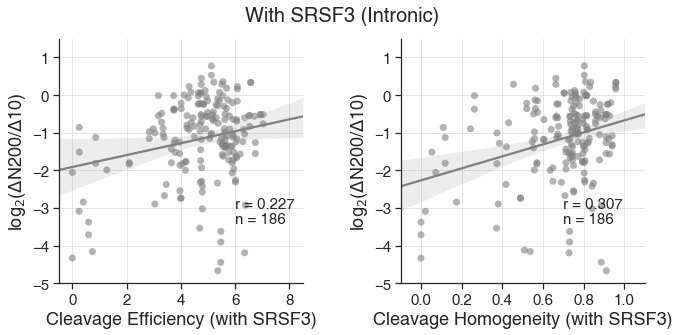

In [193]:
fig, ax = plt.subplots(1,2, figsize = (10.5,4.5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax[0].set_xlim(-0.5,8.5)
ax[0].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Efficiency_SRSF", y="log2FoldChange", data=vs_KJ_intron, ax = ax[0], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Efficiency_SRSF"], vs_KJ_intron["log2FoldChange"])[0]
ax[0].text(6,-3, 'r = %.3f'%r0, fontsize = 15)
ax[0].text(6,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].set_xlabel("Cleavage Efficiency (with SRSF3)", fontsize=18)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
# ax[0].set_title("HCT116", fontsize=20)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

ax[1].set_xlim(-0.1,1.1)
ax[1].set_ylim(-5,1.5)

sns.regplot(x="Cleavage Homogeneity_SRSF", y="log2FoldChange", data=vs_KJ_intron, ax = ax[1], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})
r0 = stats.pearsonr(vs_KJ_intron["Cleavage Homogeneity_SRSF"], vs_KJ_intron["log2FoldChange"])[0]
ax[1].text(0.7,-3, 'r = %.3f'%r0, fontsize = 15)
ax[1].text(0.7,-3.4, 'n = ' + str((len(vs_KJ_intron))), fontsize = 15)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].set_xlabel("Cleavage Homogeneity (with SRSF3)", fontsize=18)
ax[1].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
#ax[1].set_title("HCT116", fontsize=20)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

plt.suptitle("With SRSF3 (Intronic)", fontsize=20)
# #plt.savefig("../../200521_HCT116_analysis/Results/Figures/210129-SAFB12-HEK293T-HCT116-HEK293E.pdf", bbox_inches='tight')

In [196]:
vs_KJ_intron.head()

,log2FoldChange,Exon_Intron,Cleavage Efficiency_MP,Cleavage Homogeneity_MP,Cleavage Efficiency_SRSF,Cleavage Homogeneity_SRSF,CE_MP_group,CH_MP_group,CE_SRSF_group,CH_SRSF_group
mature,,,,,,,,,,
hsa-let-7a-2-3p,-0.901333,intronic,3.272476,0.787974,5.804210,0.767239,High,High,High,High
hsa-let-7c-5p,-0.235136,intronic,0.000000,0.119761,4.632084,0.666916,Low,Low,Low,Low
hsa-let-7d-3p,-2.068898,intronic,2.908662,0.492728,5.892324,0.802592,Middle,Low,High,Low
hsa-let-7d-5p,-1.795197,intronic,2.908662,0.492728,5.892324,0.802592,Middle,Low,High,Low
hsa-let-7e-3p,-1.399991,intronic,4.009412,0.651432,5.630438,0.553544,High,Middle,High,Middle


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=3.092e-01 U_stat=1.718e+03
Middle v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=1.452e-01 U_stat=1.630e+03
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=7.846e-03 U_stat=1.390e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=1.258e-01 U_stat=1.642e+03
Middle v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=9.980e-01 U_stat=1.892e+03
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=2.265e-01 U_stat=1.679e+03


Text(0.5, 0.98, 'Only MP (Intronic)')

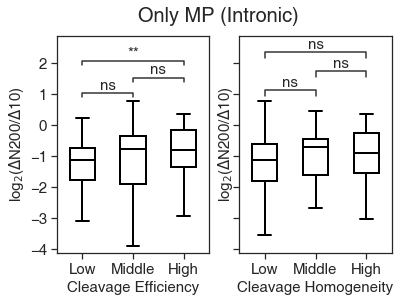

In [197]:
fig, ax = plt.subplots(1,2, figsize=(6,4), sharey=True)

ax[0] = sns.boxplot(x='CE_MP_group', y = "log2FoldChange", data=vs_KJ_intron, color='black', order=['Low','Middle', 'High'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[0], width=0.5, fliersize=3.5, linewidth=2)

ax[0].set_xlabel("Cleavage Efficiency", fontsize=15)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=15)

add_stat_annotation(ax[0], data=vs_KJ_intron, x='CE_MP_group', y ='log2FoldChange', \
                   box_pairs=[("Low", "Middle"), ("Middle", "High"), ("Low", "High")], order=['Low','Middle','High'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

ax[1] = sns.boxplot(x='CH_MP_group', y = "log2FoldChange", data=vs_KJ_intron, color='black', order=['Low','Middle', 'High'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[1], width=0.5, fliersize=3.5, linewidth=2)

ax[1].set_xlabel("Cleavage Homogeneity", fontsize=15)
ax[1].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=15)

add_stat_annotation(ax[1], data=vs_KJ_intron, x='CH_MP_group', y ='log2FoldChange', \
                   box_pairs=[("Low", "Middle"), ("Middle", "High"), ("Low", "High")], order=['Low','Middle','High'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

plt.suptitle("Only MP (Intronic)", fontsize=20)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=4.713e-03 U_stat=1.356e+03
Middle v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=4.643e-02 U_stat=2.321e+03
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=1.678e-01 U_stat=1.646e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=1.258e-01 U_stat=1.642e+03
Middle v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=9.980e-01 U_stat=1.892e+03
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided, P_val=2.265e-01 U_stat=1.679e+03


Text(0.5, 0.98, 'With SRSF (Intronic)')

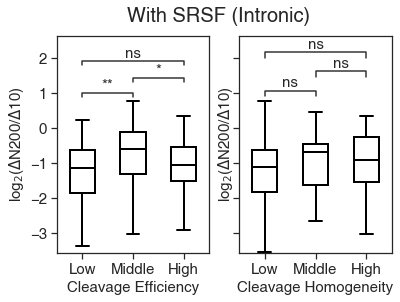

In [198]:
fig, ax = plt.subplots(1,2, figsize=(6,4), sharey=True)

ax[0] = sns.boxplot(x='CE_SRSF_group', y = "log2FoldChange", data=vs_KJ_intron, color='black', order=['Low','Middle', 'High'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[0], width=0.5, fliersize=3.5, linewidth=2)

ax[0].set_xlabel("Cleavage Efficiency", fontsize=15)
ax[0].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=15)

add_stat_annotation(ax[0], data=vs_KJ_intron, x='CE_SRSF_group', y ='log2FoldChange', \
                   box_pairs=[("Low", "Middle"), ("Middle", "High"), ("Low", "High")], order=['Low','Middle','High'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

ax[1] = sns.boxplot(x='CH_SRSF_group', y = "log2FoldChange", data=vs_KJ_intron, color='black', order=['Low','Middle', 'High'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[1], width=0.5, fliersize=3.5, linewidth=2)

ax[1].set_xlabel("Cleavage Homogeneity", fontsize=15)
ax[1].set_ylabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=15)

add_stat_annotation(ax[1], data=vs_KJ_intron, x='CH_SRSF_group', y ='log2FoldChange', \
                   box_pairs=[("Low", "Middle"), ("Middle", "High"), ("Low", "High")], order=['Low','Middle','High'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

plt.suptitle("With SRSF (Intronic)", fontsize=20)

In [204]:
vs_KJ_intron['CE_MP_group'].value_counts()

High      62
Middle    62
Low       62
Name: CE_MP_group, dtype: int64